In [38]:
'''
@File    :   energy_ranges.ipynb
@Time    :   2023/07/06 02:59:54
@Author  :   Ravi K.
@Desc    :   A notebook comparing the lc files generated \
            for different energy ranges
'''

'\n@File    :   energy_ranges.ipynb\n@Time    :   2023/07/06 02:59:54\n@Author  :   Ravi K.\n@Desc    :   A notebook comparing the lc files generated             for different energy ranges\n'

In [39]:
from astropy.io import fits
from scipy.stats import skewnorm
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import os
import processing_functions as pf
import numpy as np
%matplotlib inline
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [40]:
def gen_energy_bins(directory, n_bins=3):
    '''
    Generates energy bins for the given number of bins
    '''
    if n_bins!=3:
        energy_ranges = np.linspace(20, 200, n_bins+1)
    else:
        energy_ranges = [20, 60, 100, 200]
    if not os.path.exists(f"{directory}/{n_bins}bins"):
        os.mkdir(f"{directory}/{n_bins}_bins")
    for i in range(n_bins):
        emin = energy_ranges[i]
        emax = energy_ranges[i+1]
        print(energy_ranges[i], energy_ranges[i+1])
        os.system("python3 pipelinev3.py -d {} -emin {} -emax {}".format(directory, emin, emax))
        os.mkdir(f"{directory}/{n_bins}_bins/{int(emin)}-{int(emax)}")
        os.system(f"mv {directory}/*.lc {directory}/{n_bins}_bins/{int(emin)}-{int(emax)}/")

In [41]:
# '''automate the generation of lc files for different energy ranges'''
# n_bins = 3
# # energy_ranges = np.linspace(20, 200, n_bins+1)
# energy_ranges = [20, 60, 100, 200]
# d = "/home/ravioli/astro/ksp/grb/GRB190928A/1s"
# os.mkdir(f"{d}/{n_bins}bins")
# for i in range(n_bins):
#     emin = energy_ranges[i]
#     emax = energy_ranges[i+1]
#     print(energy_ranges[i], energy_ranges[i+1])
#     os.system("python3 pipelinev3.py -d {} -emin {} -emax {}".format(d, emin, emax))
#     os.mkdir(f"{d}/{n_bins}bins/{int(emin)}-{int(emax)}")
#     os.system(f"mv {d}/*.lc {d}/{n_bins}bins/{int(emin)}-{int(emax)}/")

In [76]:
def outlier(filename, start, end):
    *_, popt = pf.snr_skewnorm(filename, start, end)
    t, *_, start, end = pf.quadratic_detrend(filename, start, end)
    mean, std = -popt[2], skewnorm.std(popt[1], scale=popt[3])
    noise = np.concatenate((t['RATE'][:start], np.ones_like(t['RATE'][start:end])*np.nan, t['RATE'][end:])) + mean
    outliers = np.where(noise > mean + 3*std)[0]
    return outliers

def snr_outlier(filename1, filename2, start, end):
    outliers = outlier(filename1, start, end)
    *_, popt = pf.snr_skewnorm(filename2, start, end)
    mean, std = -popt[2], skewnorm.std(popt[1], scale=popt[3])
    t, *_, start, end = pf.quadratic_detrend(filename2, start, end)
    signal = t['RATE'][outliers]+mean
    noise = mean+3*std
    snr = signal/noise
    return snr

def snr_grb(filename, start, end):
    t, *_, start, end = pf.quadratic_detrend(filename, start, end)
    signal = max(t['RATE'][start:end])
    noise = sigma_clipped_stats(t['RATE'], sigma=3)[2] + sigma_clipped_stats(t['RATE'], sigma=3)[0]
    snr = signal/noise
    return signal, noise, snr

In [43]:
grb_time = (307372000, 307373000)

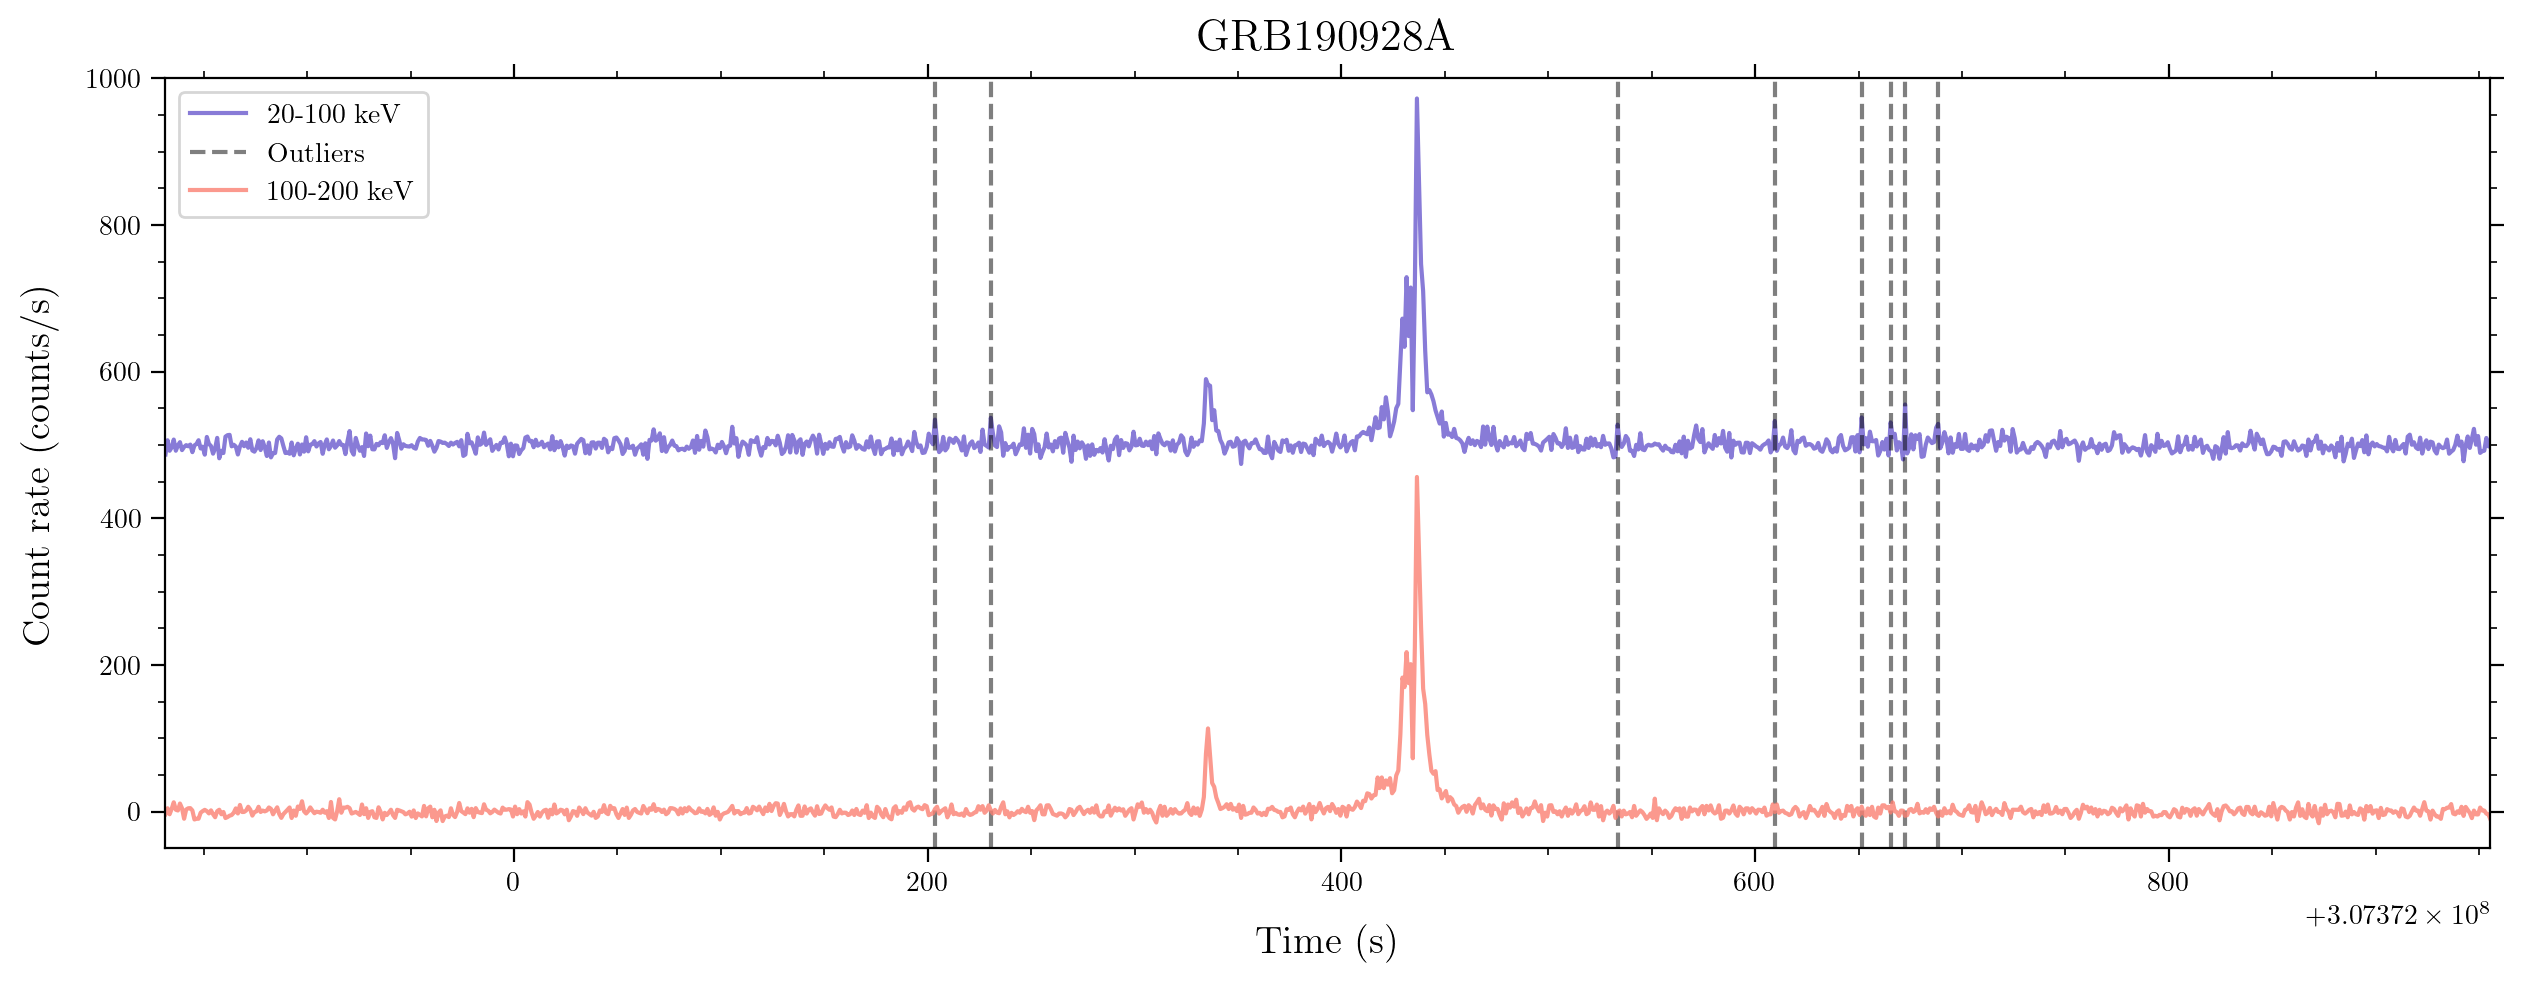

In [44]:
lc_2bin_1 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/2bins/20-100/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_2bin_2 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/2bins/100-200/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
snr_2bin_1_skewnorm, *_, popt_2bin_1_skewnorm = pf.snr_skewnorm(lc_2bin_1, 1691, 1823)
snr_2bin_2_skewnorm, *_, popt_2bin_2_skewnorm = pf.snr_skewnorm(lc_2bin_2, 1691, 1823)
outliers_2bin_1 = outlier(lc_2bin_1, 1691, 1823)
t_2bin_1, *_ = pf.quadratic_detrend(lc_2bin_1, 1691, 1823)
t_2bin_2, *_ = pf.quadratic_detrend(lc_2bin_2, 1691, 1823)
snr_2bin_1_outlier = snr_outlier(lc_2bin_1, lc_2bin_1, 1691, 1823)
snr_2bin_2_outlier = snr_outlier(lc_2bin_1, lc_2bin_2, 1691, 1823)
plt.figure(figsize=(15, 5), dpi=200)
plt.plot(t_2bin_1['TIME'], t_2bin_1['RATE']+500, color='slateblue', alpha=0.8, label="20-100 keV")
plt.vlines(t_2bin_1['TIME'][outliers_2bin_1], -50, 1000, linestyles='--', color='black', alpha=0.5, label="Outliers")
plt.plot(t_2bin_2['TIME'], t_2bin_2['RATE'], color='salmon', alpha=0.8, label="100-200 keV")
plt.ylim(-50, 1000)
plt.xlim(t_2bin_1['TIME'][0], t_2bin_1['TIME'][-1])
plt.xlabel("Time (s)", labelpad=10, fontsize=14)
plt.ylabel("Count rate (counts/s)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.legend(loc='upper left')
plt.show()

In [45]:
lc_3bin_1 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/20-60/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_3bin_2 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/60-100/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_3bin_3 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/100-200/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"

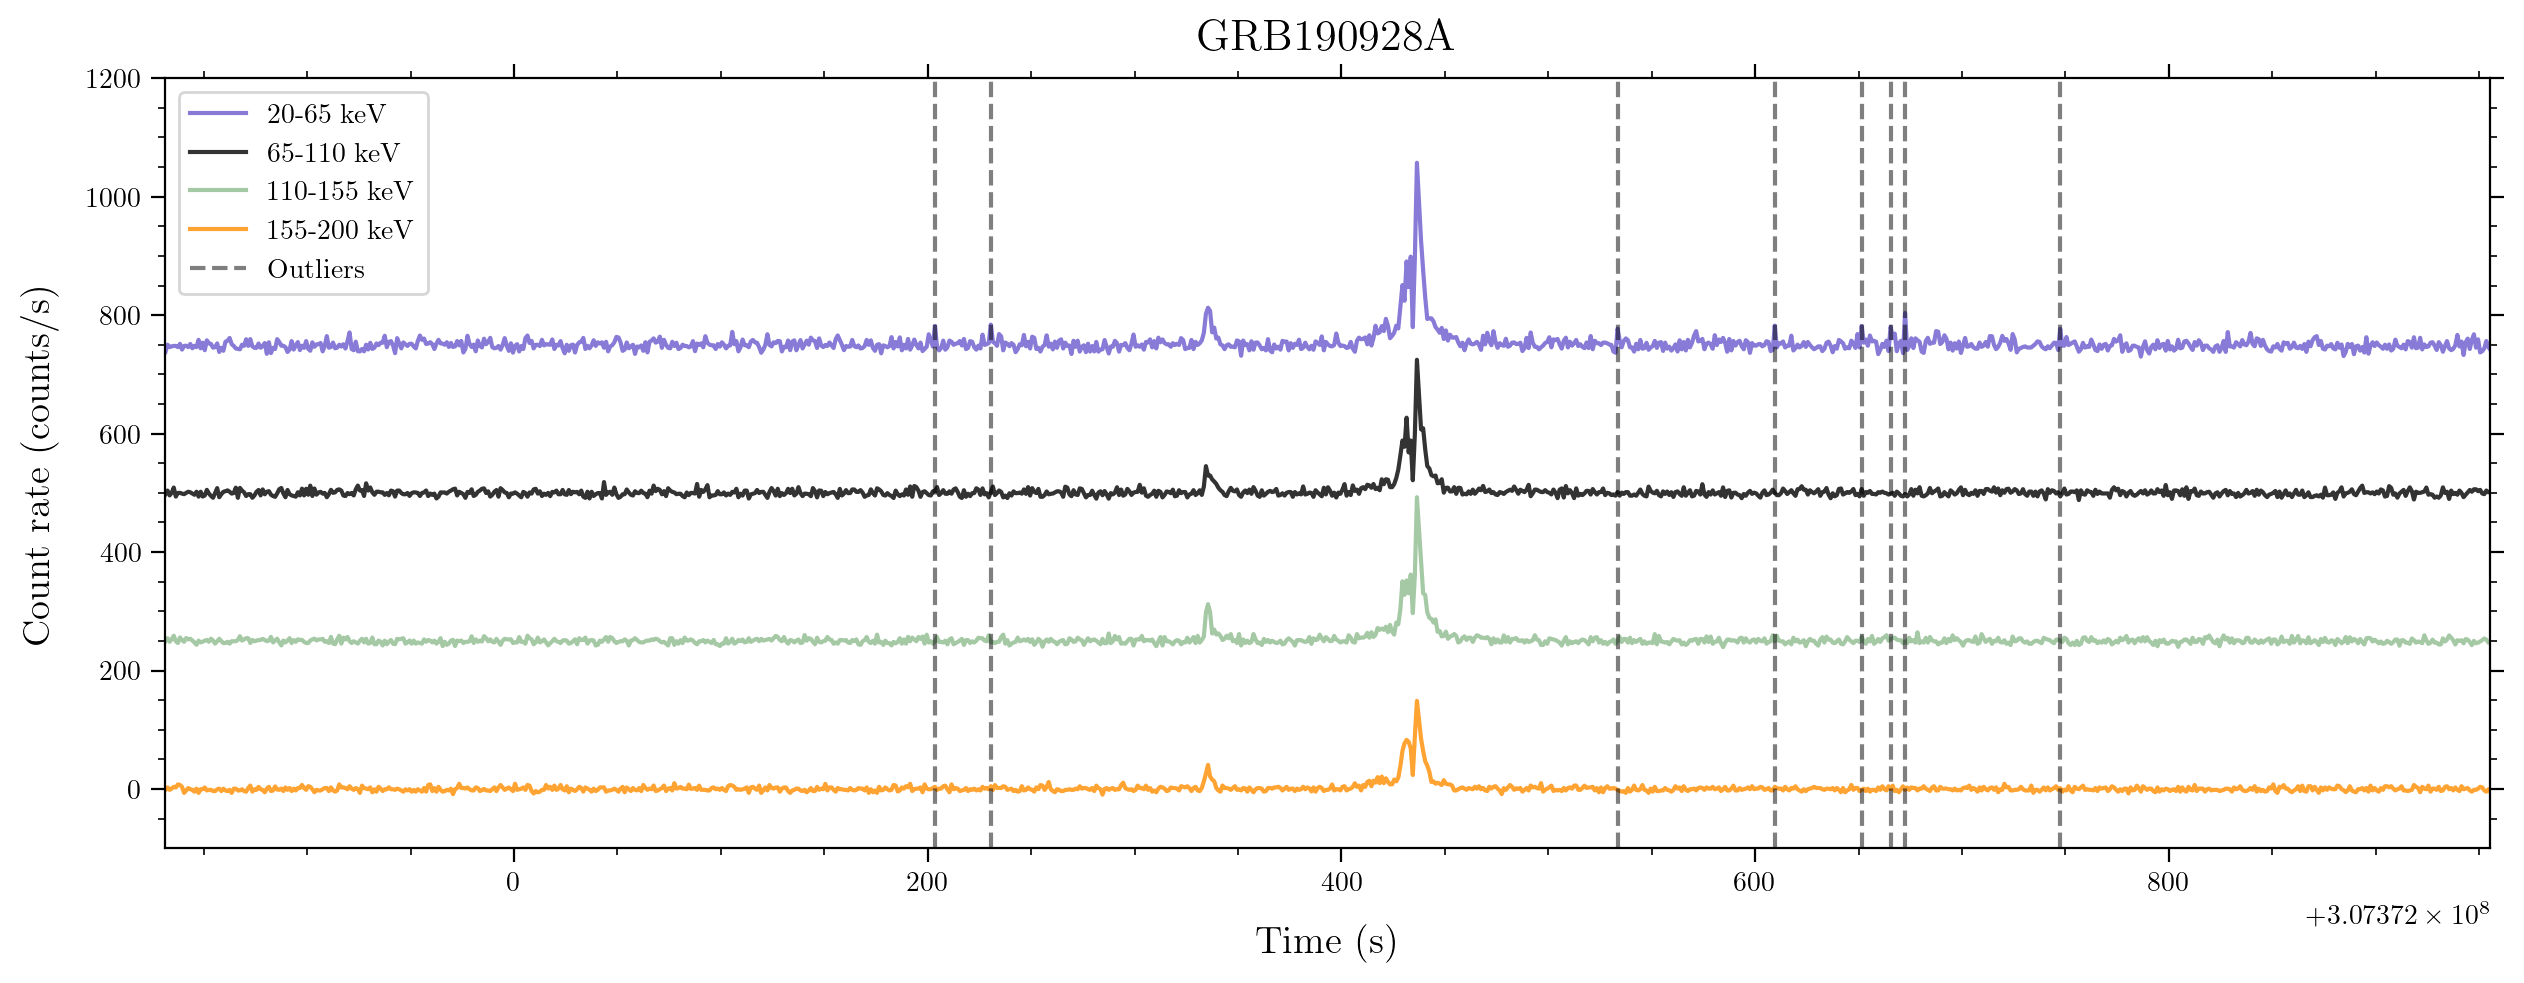

In [46]:
lc_4bin_1 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/4bins/20-65/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_4bin_2 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/4bins/65-110/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_4bin_3 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/4bins/110-155/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_4bin_4 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/4bins/155-200/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
snr_4bin_1_skewnorm, *_, popt_4bin_1_skewnorm = pf.snr_skewnorm(lc_4bin_1, 1691, 1823)
snr_4bin_2_skewnorm, *_, popt_4bin_2_skewnorm = pf.snr_skewnorm(lc_4bin_2, 1691, 1823)
snr_4bin_3_skewnorm, *_, popt_4bin_3_skewnorm = pf.snr_skewnorm(lc_4bin_3, 1691, 1823)
snr_4bin_4_skewnorm, *_, popt_4bin_4_skewnorm = pf.snr_skewnorm(lc_4bin_4, 1691, 1823)
outliers_4bin_1 = outlier(lc_4bin_1, 1691, 1823)
t_4bin_1, *_ = pf.quadratic_detrend(lc_4bin_1, 1691, 1823)
t_4bin_2, *_ = pf.quadratic_detrend(lc_4bin_2, 1691, 1823)
t_4bin_3, *_ = pf.quadratic_detrend(lc_4bin_3, 1691, 1823)
t_4bin_4, *_ = pf.quadratic_detrend(lc_4bin_4, 1691, 1823)
snr_4bin_1_outlier = snr_outlier(lc_4bin_1, lc_4bin_1, 1691, 1823)
snr_4bin_2_outlier = snr_outlier(lc_4bin_1, lc_4bin_2, 1691, 1823)
snr_4bin_3_outlier = snr_outlier(lc_4bin_1, lc_4bin_3, 1691, 1823)
snr_4bin_4_outlier = snr_outlier(lc_4bin_1, lc_4bin_4, 1691, 1823)
plt.figure(figsize=(15, 5), dpi=200)
plt.plot(t_4bin_1['TIME'], t_4bin_1['RATE']+750, color='slateblue', alpha=0.8, label="20-65 keV")
plt.plot(t_4bin_2['TIME'], t_4bin_2['RATE']+500, color='black', alpha=0.8, label="65-110 keV")
plt.plot(t_4bin_3['TIME'], t_4bin_3['RATE']+250, color='darkseagreen', alpha=0.8, label="110-155 keV")
plt.plot(t_4bin_4['TIME'], t_4bin_4['RATE'], color='darkorange', alpha=0.8, label="155-200 keV")
plt.vlines(t_4bin_1['TIME'][outliers_4bin_1], -100, 1200, linestyles='--', color='black', alpha=0.5, label="Outliers")
plt.ylim(-100, 1200)
plt.xlim(t_4bin_1['TIME'][0], t_4bin_1['TIME'][-1])
plt.xlabel("Time (s)", labelpad=10, fontsize=14)
plt.ylabel("Count rate (counts/s)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.legend(loc='upper left')
plt.show()

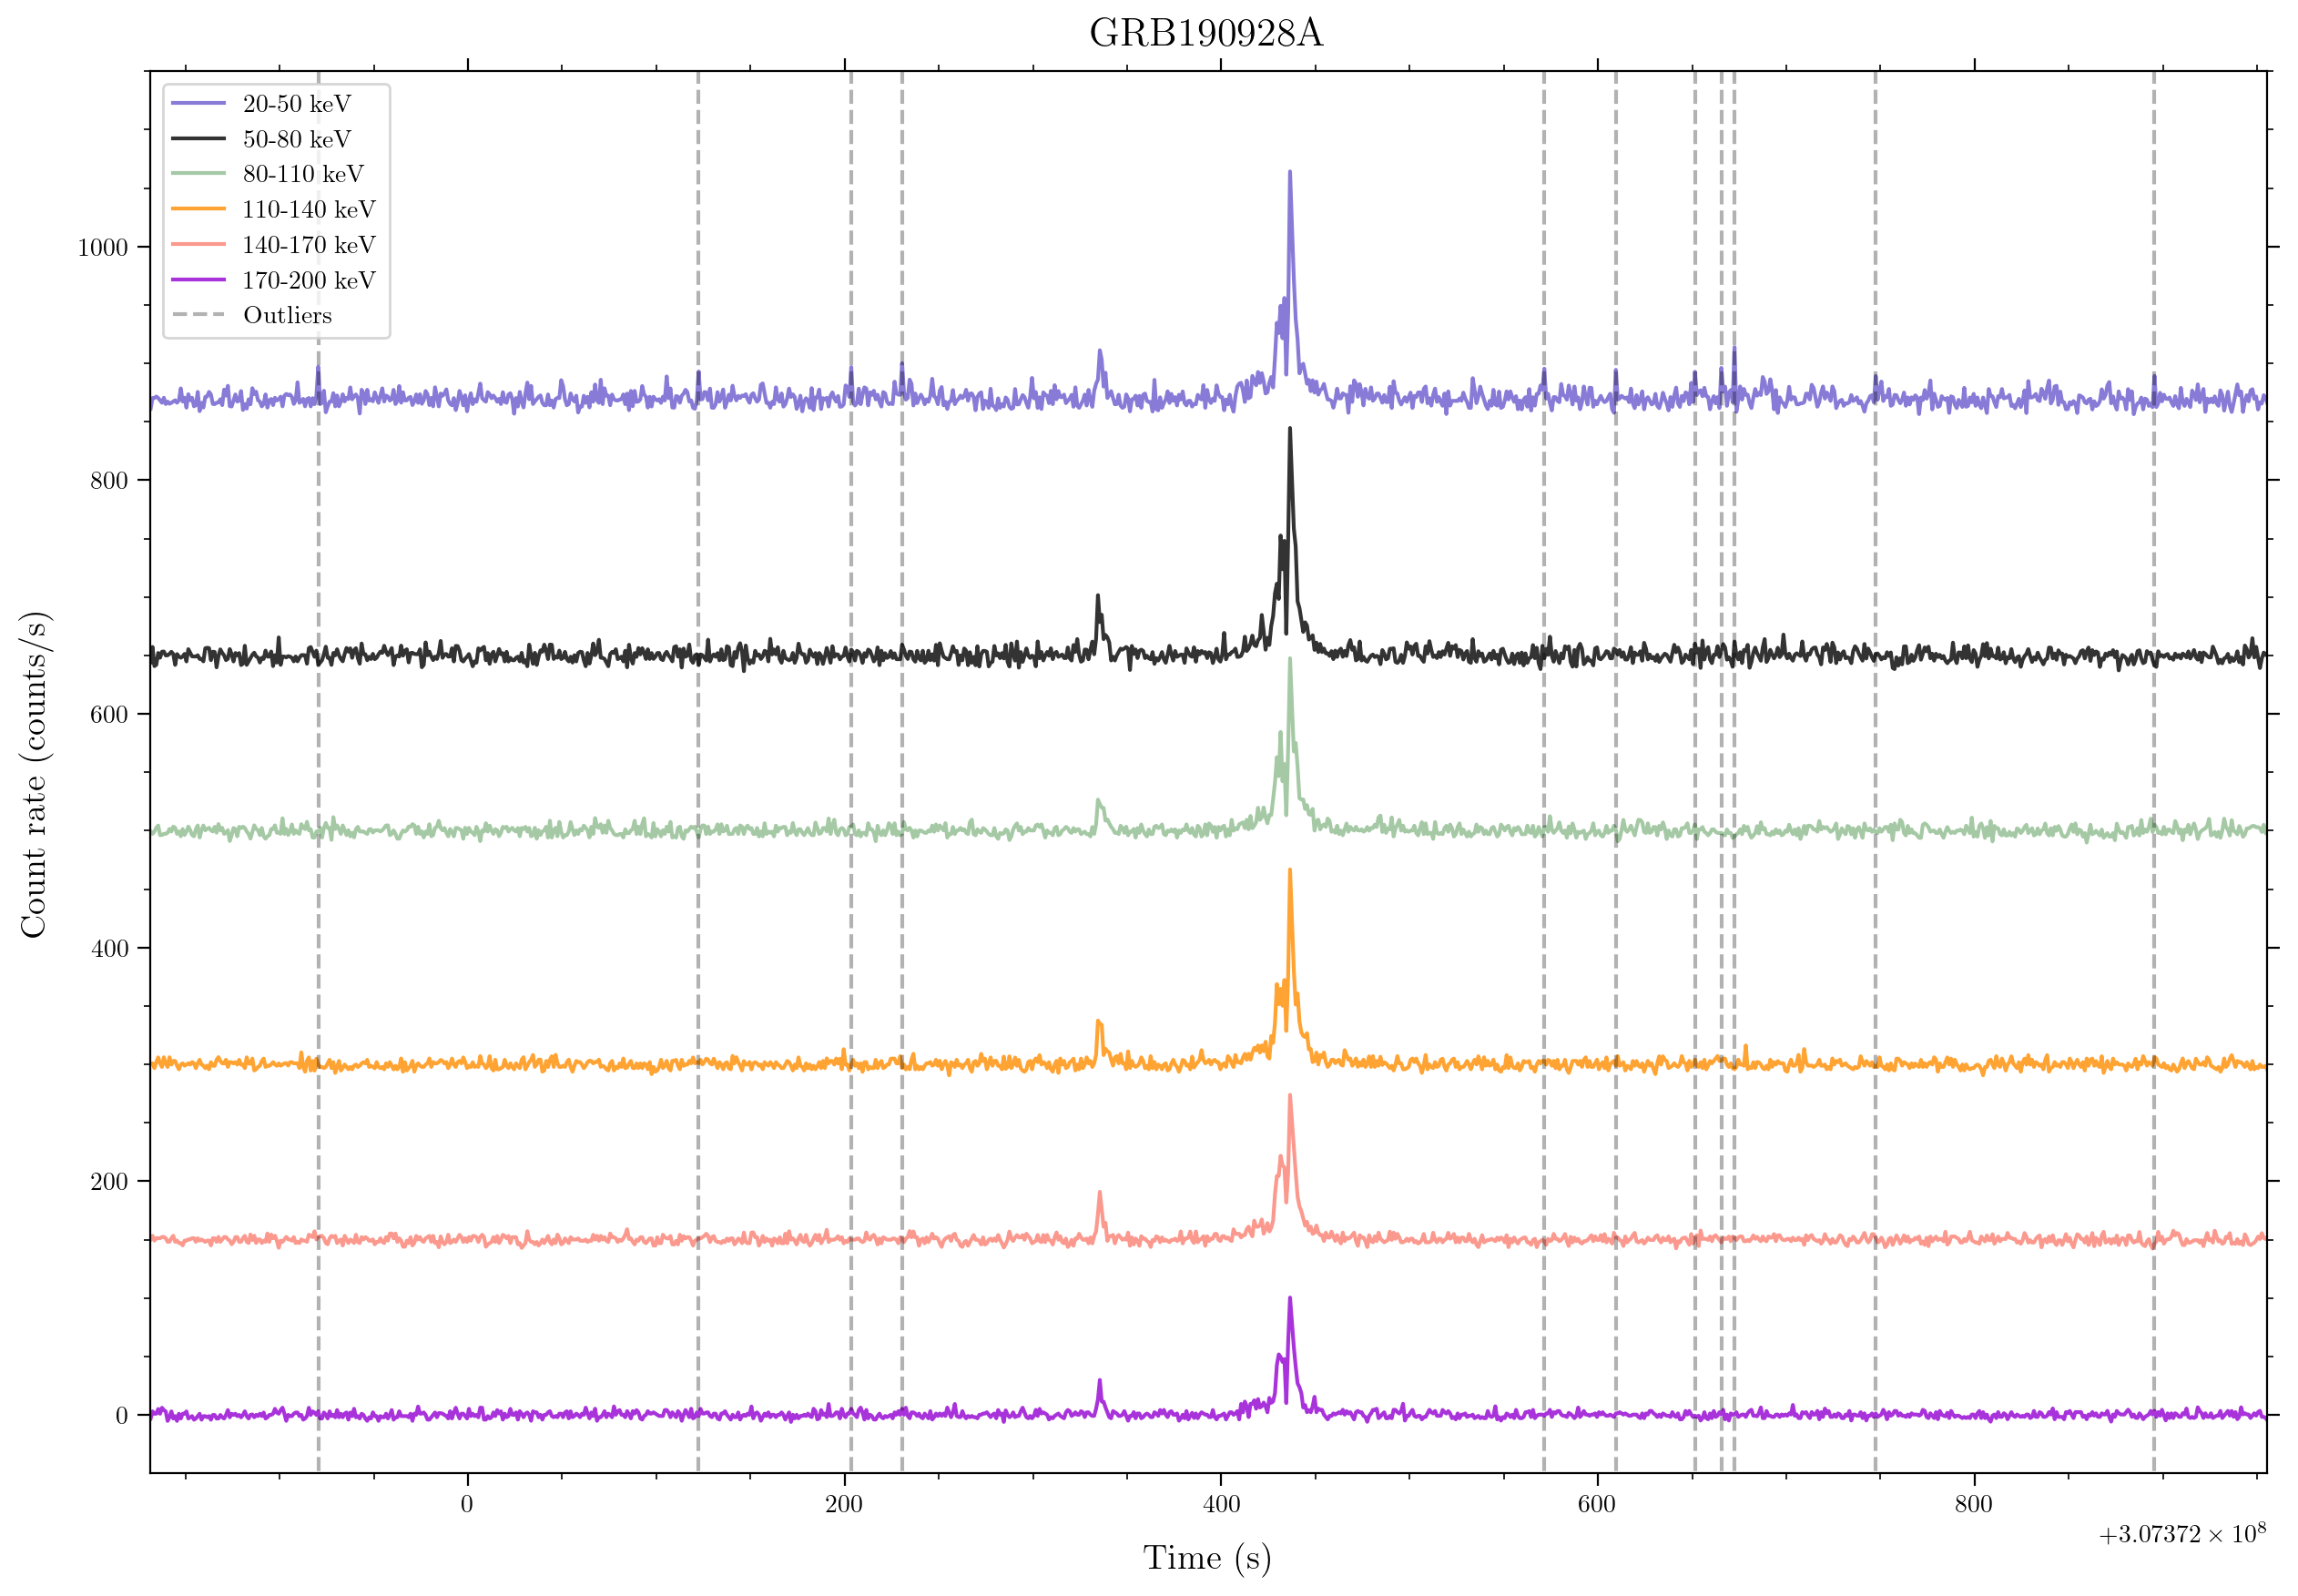

In [47]:
lc_6bin_1 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/6bins/20-50/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_6bin_2 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/6bins/50-80/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_6bin_3 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/6bins/80-110/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_6bin_4 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/6bins/110-140/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_6bin_5 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/6bins/140-170/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_6bin_6 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/6bins/170-200/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
snr_6bin_1_skewnorm, *_, popt_6bin_1_skewnorm = pf.snr_skewnorm(lc_6bin_1, 1691, 1823)
snr_6bin_2_skewnorm, *_, popt_6bin_2_skewnorm = pf.snr_skewnorm(lc_6bin_2, 1691, 1823)
snr_6bin_3_skewnorm, *_, popt_6bin_3_skewnorm = pf.snr_skewnorm(lc_6bin_3, 1691, 1823)
snr_6bin_4_skewnorm, *_, popt_6bin_4_skewnorm = pf.snr_skewnorm(lc_6bin_4, 1691, 1823)
snr_6bin_5_skewnorm, *_, popt_6bin_5_skewnorm = pf.snr_skewnorm(lc_6bin_5, 1691, 1823)
snr_6bin_6_skewnorm, *_, popt_6bin_6_skewnorm = pf.snr_skewnorm(lc_6bin_6, 1691, 1823)
outliers_6bin_1 = outlier(lc_6bin_1, 1691, 1823)
t_6bin_1, *_ = pf.quadratic_detrend(lc_6bin_1, 1691, 1823)
t_6bin_2, *_ = pf.quadratic_detrend(lc_6bin_2, 1691, 1823)
t_6bin_3, *_ = pf.quadratic_detrend(lc_6bin_3, 1691, 1823)
t_6bin_4, *_ = pf.quadratic_detrend(lc_6bin_4, 1691, 1823)
t_6bin_5, *_ = pf.quadratic_detrend(lc_6bin_5, 1691, 1823)
t_6bin_6, *_ = pf.quadratic_detrend(lc_6bin_6, 1691, 1823)
snr_6bin_1_outlier = snr_outlier(lc_6bin_1, lc_6bin_1, 1691, 1823)
snr_6bin_2_outlier = snr_outlier(lc_6bin_1, lc_6bin_2, 1691, 1823)
snr_6bin_3_outlier = snr_outlier(lc_6bin_1, lc_6bin_3, 1691, 1823)
snr_6bin_4_outlier = snr_outlier(lc_6bin_1, lc_6bin_4, 1691, 1823)
snr_6bin_5_outlier = snr_outlier(lc_6bin_1, lc_6bin_5, 1691, 1823)
snr_6bin_6_outlier = snr_outlier(lc_6bin_1, lc_6bin_6, 1691, 1823)
plt.figure(figsize=(15, 10), dpi=200)
plt.plot(t_6bin_1['TIME'], t_6bin_1['RATE']+870, color='slateblue', alpha=0.8, label="20-50 keV")
plt.plot(t_6bin_2['TIME'], t_6bin_2['RATE']+650, color='black', alpha=0.8, label="50-80 keV")
plt.plot(t_6bin_3['TIME'], t_6bin_3['RATE']+500, color='darkseagreen', alpha=0.8, label="80-110 keV")
plt.plot(t_6bin_4['TIME'], t_6bin_4['RATE']+300, color='darkorange', alpha=0.8, label="110-140 keV")
plt.plot(t_6bin_5['TIME'], t_6bin_5['RATE']+150, color='salmon', alpha=0.8, label="140-170 keV")
plt.plot(t_6bin_6['TIME'], t_6bin_6['RATE'], color='darkviolet', alpha=0.8, label="170-200 keV")
plt.vlines(t_6bin_1['TIME'][outliers_6bin_1], -100, 1150, linestyles='--', color='black', alpha=0.3, label="Outliers")
plt.ylim(-50, 1150)
plt.xlim(t_6bin_1['TIME'][0], t_6bin_1['TIME'][-1])
plt.xlabel("Time (s)", labelpad=10, fontsize=14)
plt.ylabel("Count rate (counts/s)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.legend(loc='upper left')
plt.show()

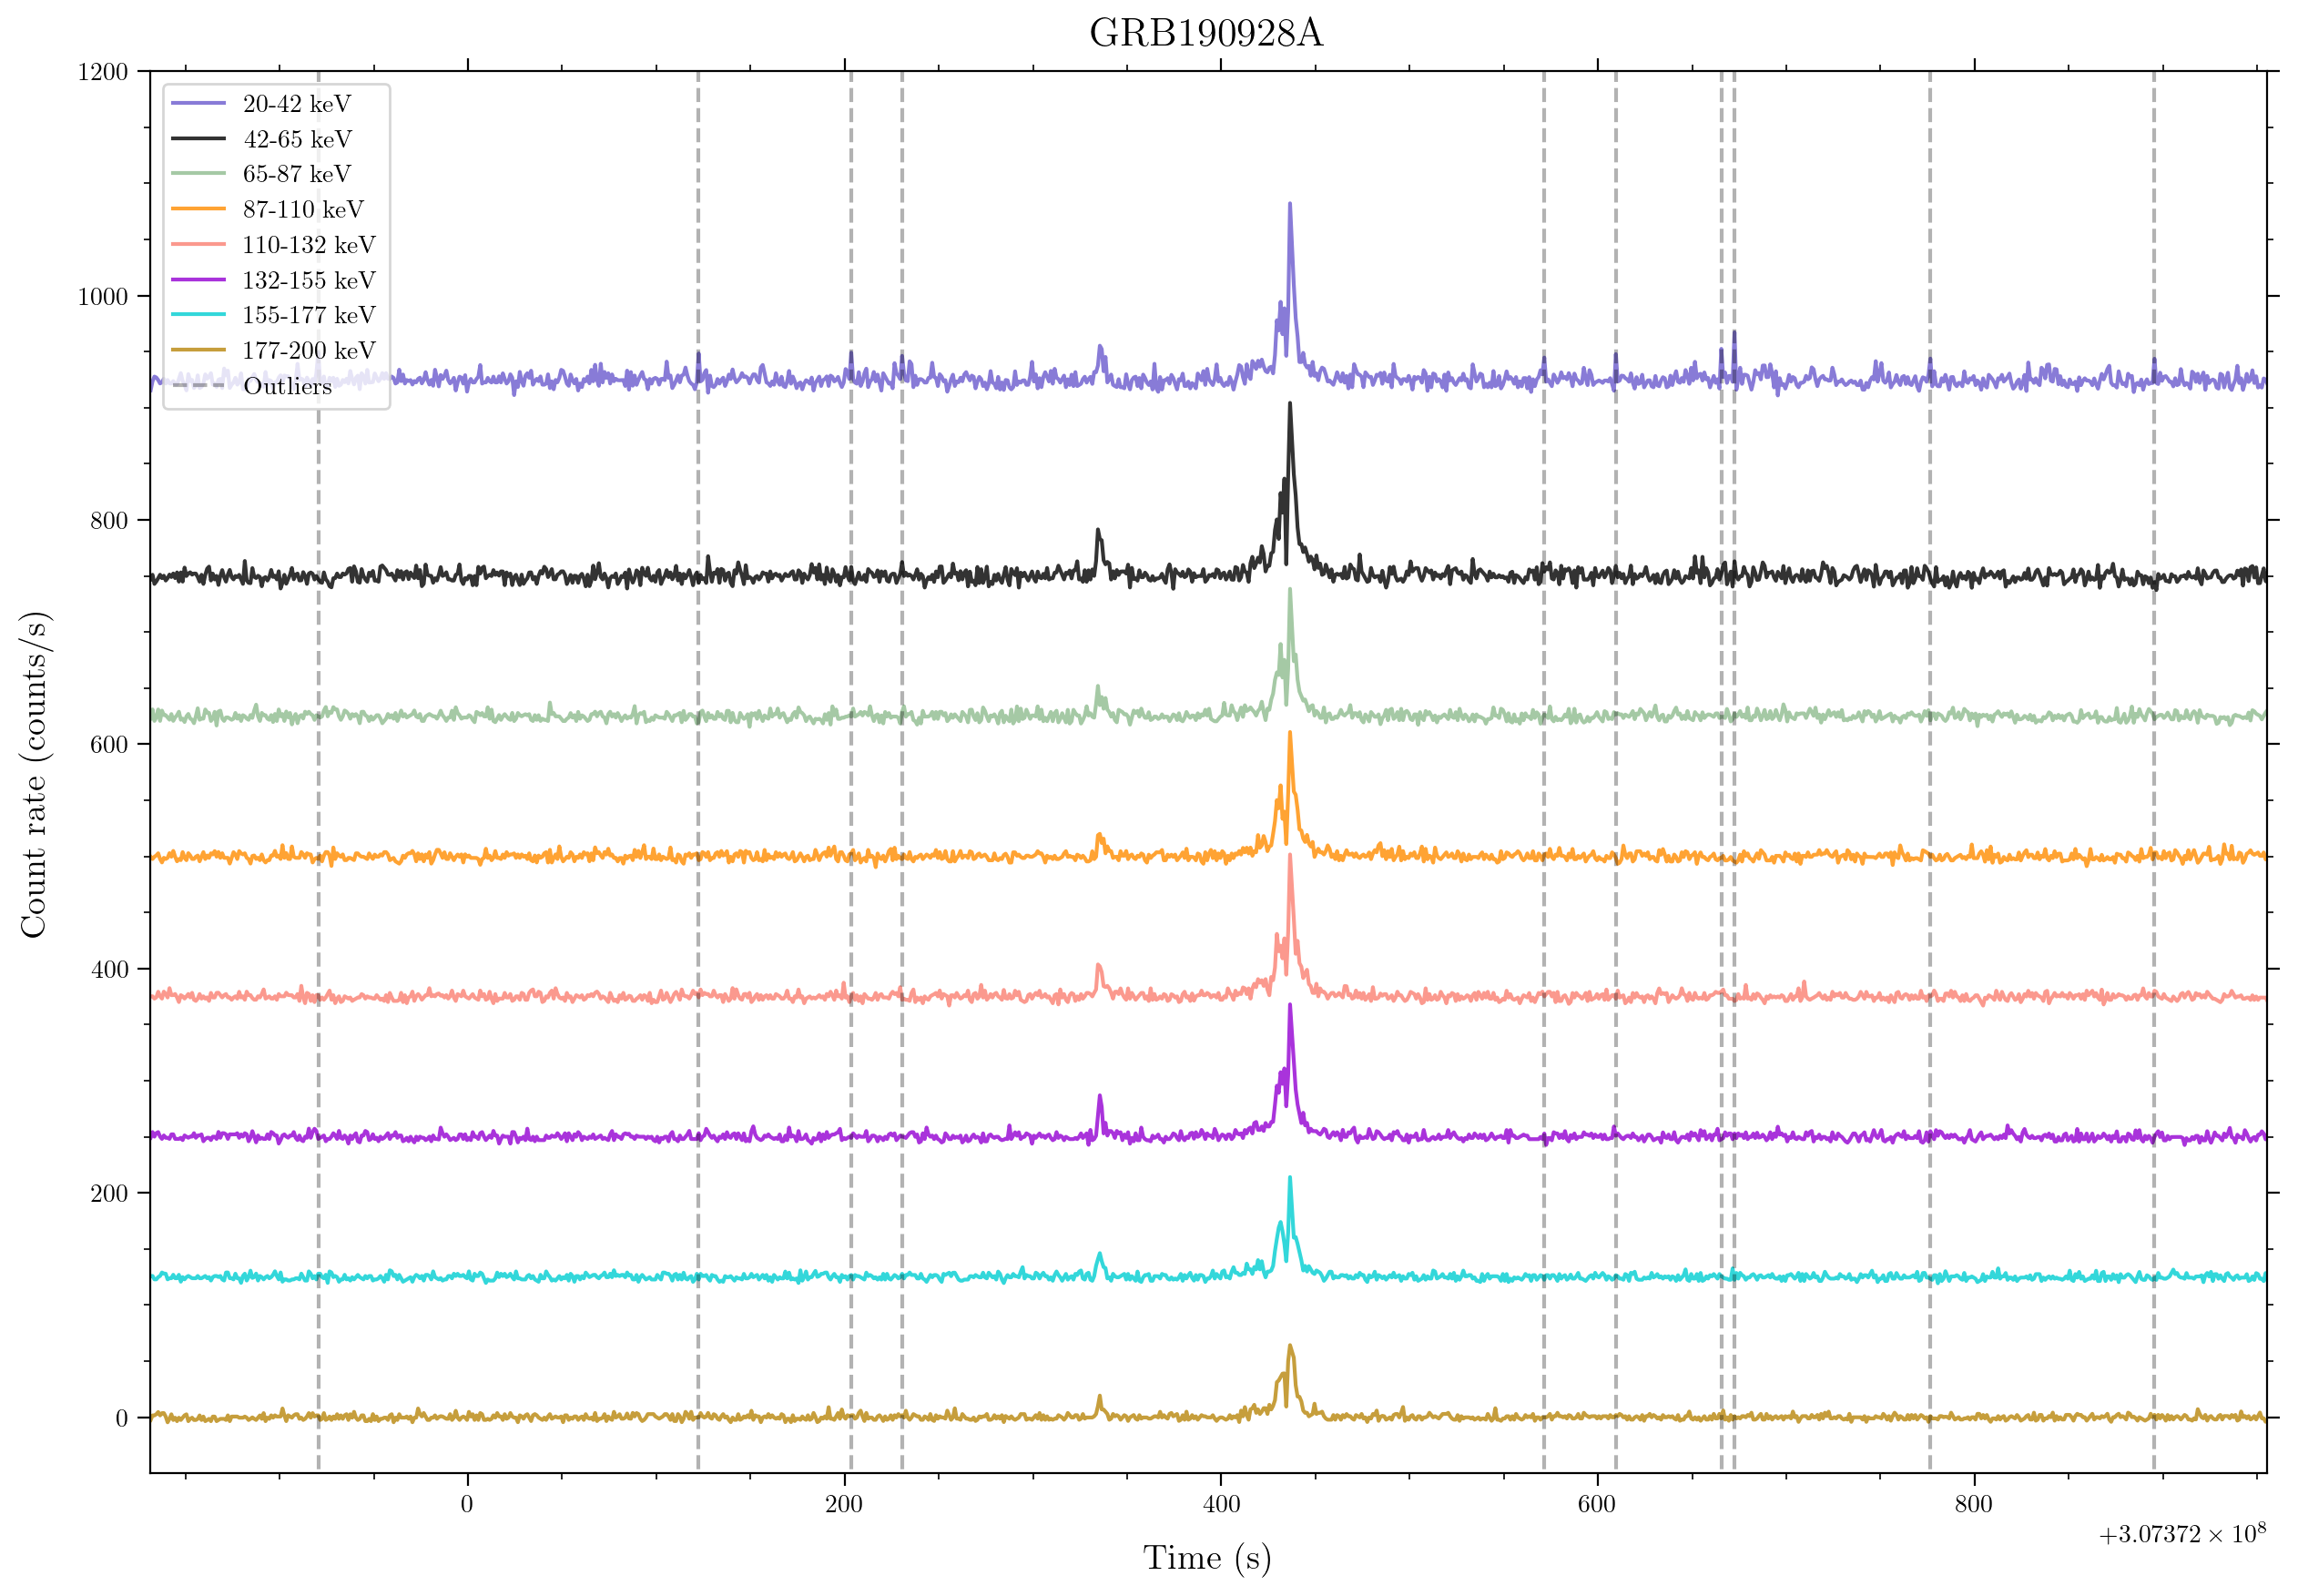

In [48]:
lc_8bin_1 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/20-42/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_8bin_2 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/42-65/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_8bin_3 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/65-87/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_8bin_4 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/87-110/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_8bin_5 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/110-132/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_8bin_6 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/132-155/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_8bin_7 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/155-177/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_8bin_8 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/8bins/177-200/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
snr_8bin_1_skewnorm, *_, popt_8bin_1_skewnorm = pf.snr_skewnorm(lc_8bin_1, 1691, 1823)
snr_8bin_2_skewnorm, *_, popt_8bin_2_skewnorm = pf.snr_skewnorm(lc_8bin_2, 1691, 1823)
snr_8bin_3_skewnorm, *_, popt_8bin_3_skewnorm = pf.snr_skewnorm(lc_8bin_3, 1691, 1823)
snr_8bin_4_skewnorm, *_, popt_8bin_4_skewnorm = pf.snr_skewnorm(lc_8bin_4, 1691, 1823)
snr_8bin_5_skewnorm, *_, popt_8bin_5_skewnorm = pf.snr_skewnorm(lc_8bin_5, 1691, 1823)
snr_8bin_6_skewnorm, *_, popt_8bin_6_skewnorm = pf.snr_skewnorm(lc_8bin_6, 1691, 1823)
snr_8bin_7_skewnorm, *_, popt_8bin_7_skewnorm = pf.snr_skewnorm(lc_8bin_7, 1691, 1823)
snr_8bin_8_skewnorm, *_, popt_8bin_8_skewnorm = pf.snr_skewnorm(lc_8bin_8, 1691, 1823)
outliers_8bin_1 = outlier(lc_8bin_1, 1691, 1823)
t_8bin_1, *_ = pf.quadratic_detrend(lc_8bin_1, 1691, 1823)
t_8bin_2, *_ = pf.quadratic_detrend(lc_8bin_2, 1691, 1823)
t_8bin_3, *_ = pf.quadratic_detrend(lc_8bin_3, 1691, 1823)
t_8bin_4, *_ = pf.quadratic_detrend(lc_8bin_4, 1691, 1823)
t_8bin_5, *_ = pf.quadratic_detrend(lc_8bin_5, 1691, 1823)
t_8bin_6, *_ = pf.quadratic_detrend(lc_8bin_6, 1691, 1823)
t_8bin_7, *_ = pf.quadratic_detrend(lc_8bin_7, 1691, 1823)
t_8bin_8, *_ = pf.quadratic_detrend(lc_8bin_8, 1691, 1823)
snr_8bin_1_outlier = snr_outlier(lc_8bin_1, lc_8bin_1, 1691, 1823)
snr_8bin_2_outlier = snr_outlier(lc_8bin_1, lc_8bin_2, 1691, 1823)
snr_8bin_3_outlier = snr_outlier(lc_8bin_1, lc_8bin_3, 1691, 1823)
snr_8bin_4_outlier = snr_outlier(lc_8bin_1, lc_8bin_4, 1691, 1823)
snr_8bin_5_outlier = snr_outlier(lc_8bin_1, lc_8bin_5, 1691, 1823)
snr_8bin_6_outlier = snr_outlier(lc_8bin_1, lc_8bin_6, 1691, 1823)
snr_8bin_7_outlier = snr_outlier(lc_8bin_1, lc_8bin_7, 1691, 1823)
snr_8bin_8_outlier = snr_outlier(lc_8bin_1, lc_8bin_8, 1691, 1823)
plt.figure(figsize=(15, 10), dpi=200)
plt.plot(t_8bin_1['TIME'], t_8bin_1['RATE']+925, color='slateblue', alpha=0.8, label="20-42 keV")
plt.plot(t_8bin_2['TIME'], t_8bin_2['RATE']+750, color='black', alpha=0.8, label="42-65 keV")
plt.plot(t_8bin_3['TIME'], t_8bin_3['RATE']+625, color='darkseagreen', alpha=0.8, label="65-87 keV")
plt.plot(t_8bin_4['TIME'], t_8bin_4['RATE']+500, color='darkorange', alpha=0.8, label="87-110 keV")
plt.plot(t_8bin_5['TIME'], t_8bin_5['RATE']+375, color='salmon', alpha=0.8, label="110-132 keV")
plt.plot(t_8bin_6['TIME'], t_8bin_6['RATE']+250, color='darkviolet', alpha=0.8, label="132-155 keV")
plt.plot(t_8bin_7['TIME'], t_8bin_7['RATE']+125, color='darkturquoise', alpha=0.8, label="155-177 keV")
plt.plot(t_8bin_8['TIME'], t_8bin_8['RATE'], color='darkgoldenrod', alpha=0.8, label="177-200 keV")
plt.vlines(t_8bin_1['TIME'][outliers_8bin_1], -100, 1200, linestyles='--', color='black', alpha=0.3, label="Outliers")
plt.ylim(-50, 1200)
plt.xlim(t_8bin_1['TIME'][0], t_8bin_1['TIME'][-1])
plt.xlabel("Time (s)", labelpad=10, fontsize=14)
plt.ylabel("Count rate (counts/s)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.legend(loc='upper left')
plt.show()

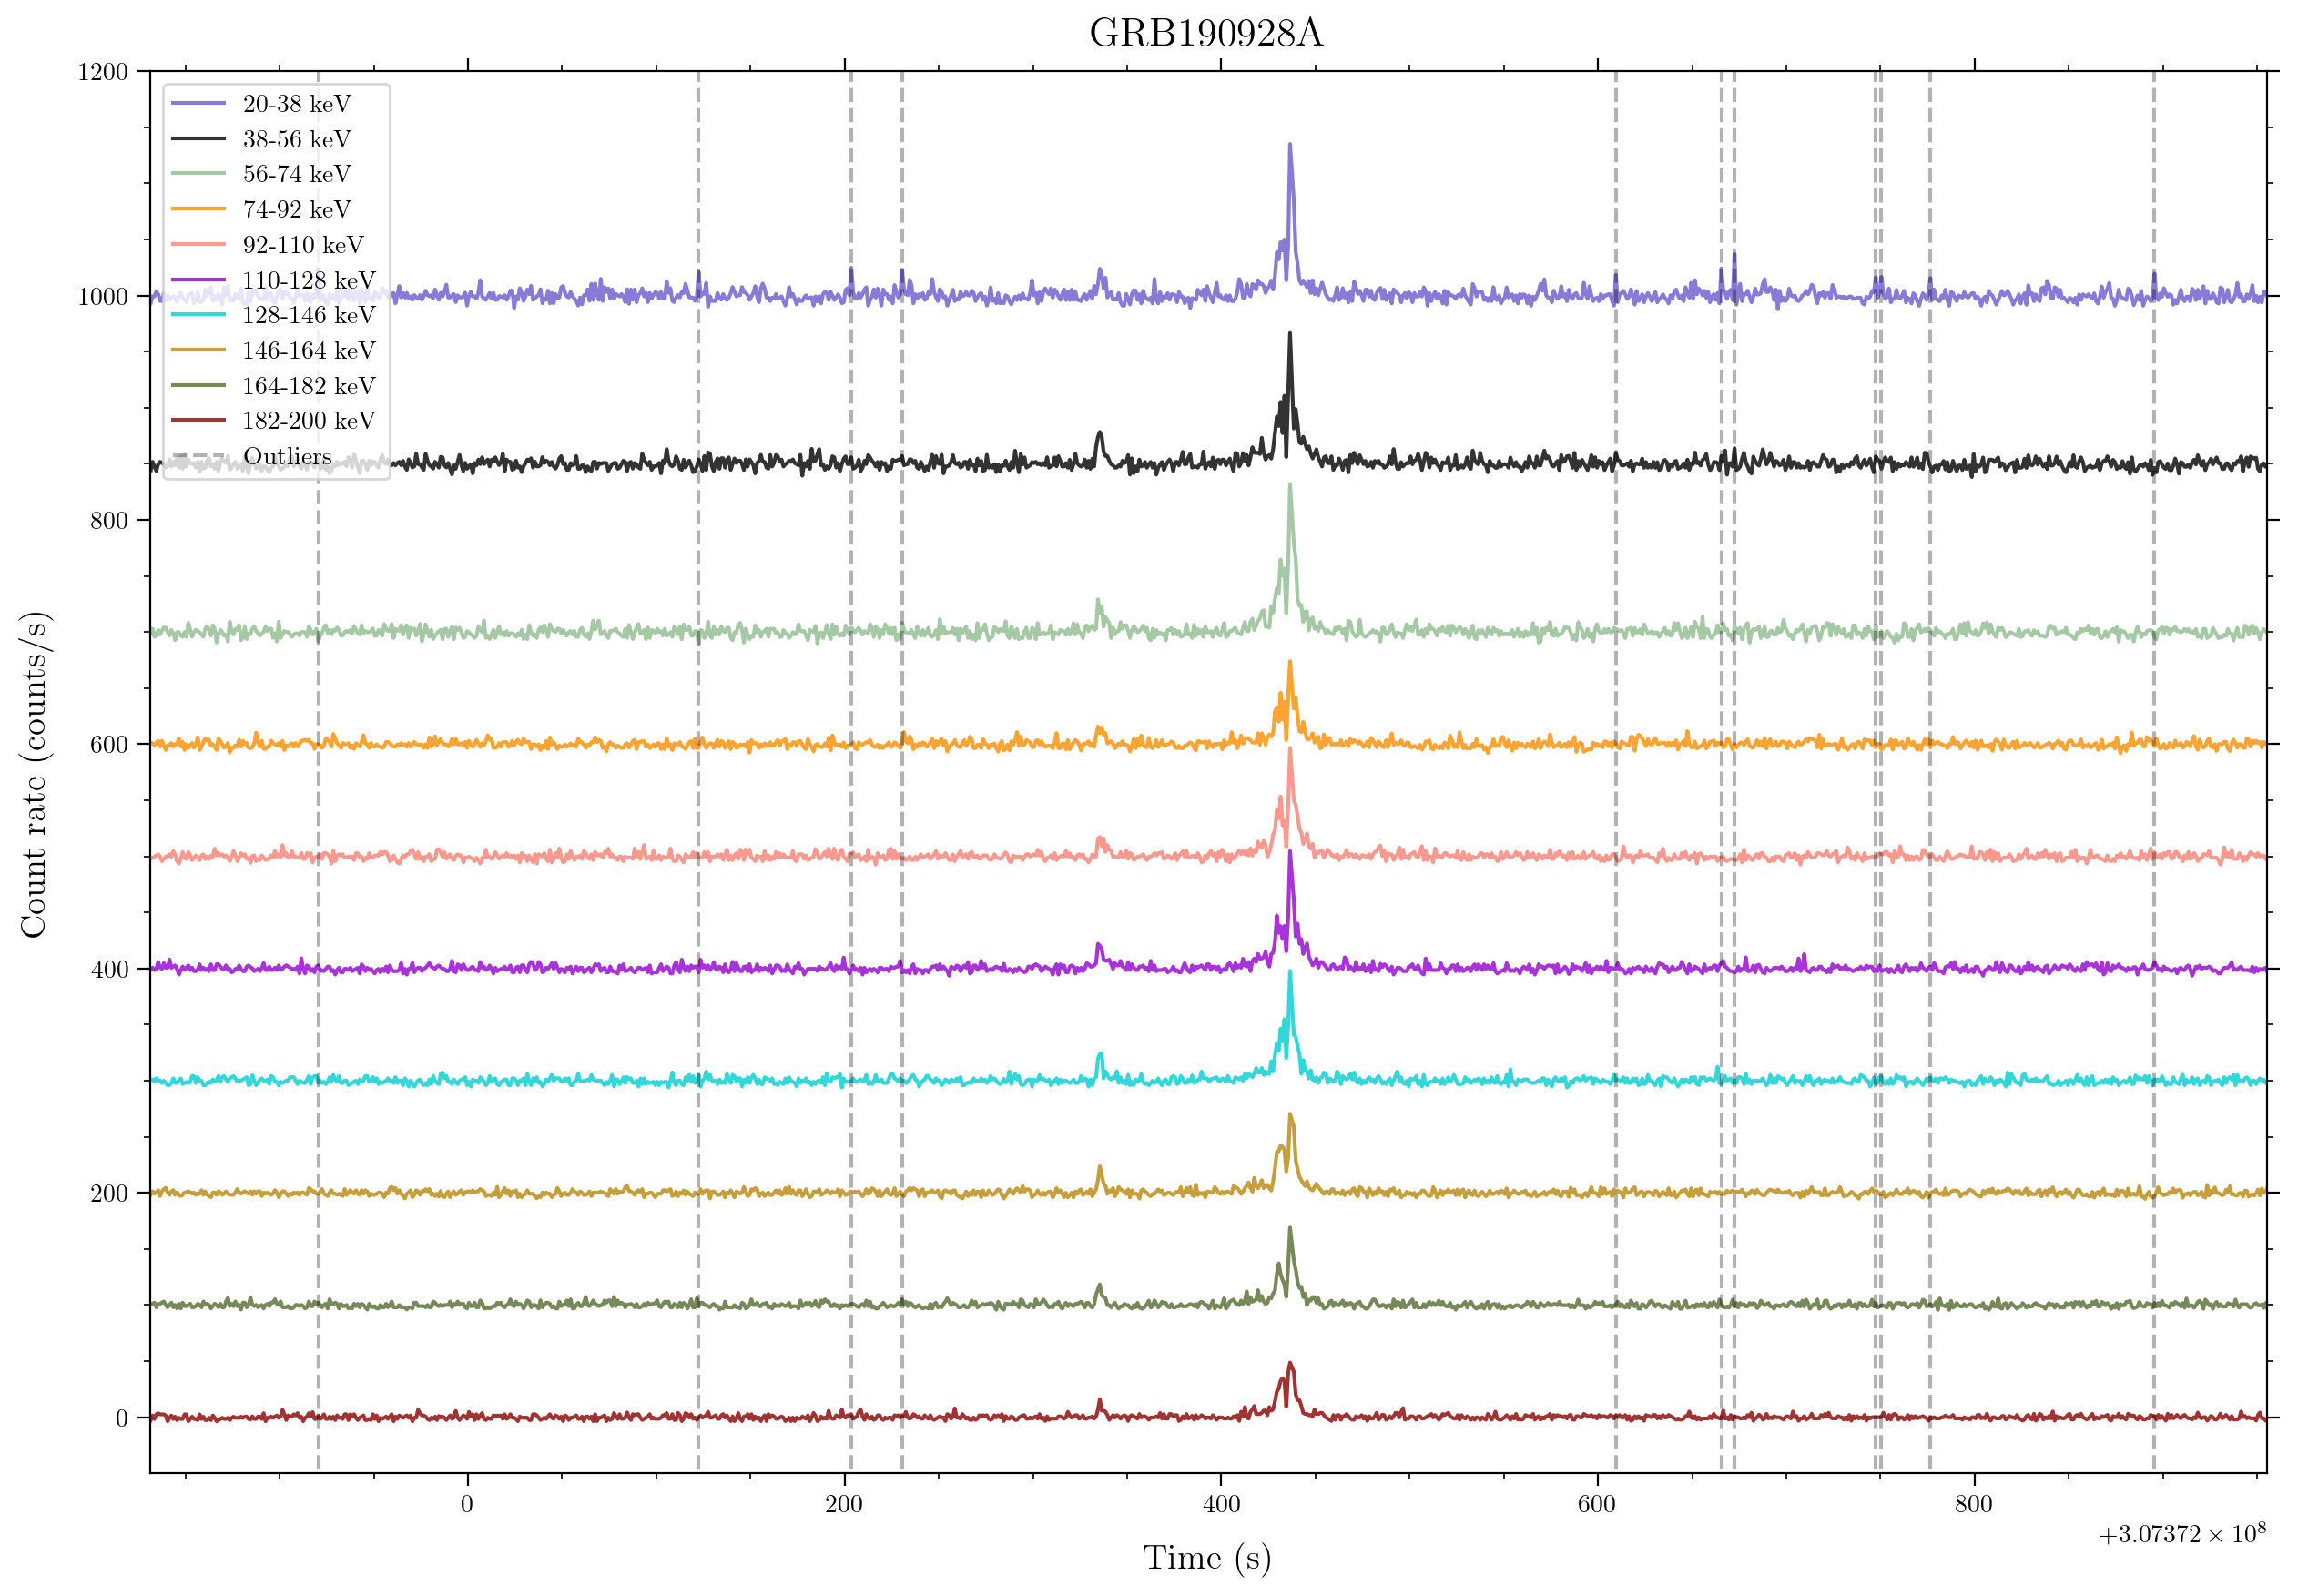

In [49]:
lc_10bin_1 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/20-38/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_2 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/38-56/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_3 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/56-74/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_4 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/74-92/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_5 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/92-110/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_6 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/110-128/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_7 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/128-146/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_8 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/146-164/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_9 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/164-182/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
lc_10bin_10 = "/home/ravioli/astro/ksp/grb/GRB190928A/1s/10bins/182-200/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc"
snr_10bin_1_skewnorm, *_, popt_10bin_1_skewnorm = pf.snr_skewnorm(lc_10bin_1, 1691, 1823)
snr_10bin_2_skewnorm, *_, popt_10bin_2_skewnorm = pf.snr_skewnorm(lc_10bin_2, 1691, 1823)
snr_10bin_3_skewnorm, *_, popt_10bin_3_skewnorm = pf.snr_skewnorm(lc_10bin_3, 1691, 1823)
snr_10bin_4_skewnorm, *_, popt_10bin_4_skewnorm = pf.snr_skewnorm(lc_10bin_4, 1691, 1823)
snr_10bin_5_skewnorm, *_, popt_10bin_5_skewnorm = pf.snr_skewnorm(lc_10bin_5, 1691, 1823)
snr_10bin_6_skewnorm, *_, popt_10bin_6_skewnorm = pf.snr_skewnorm(lc_10bin_6, 1691, 1823)
snr_10bin_7_skewnorm, *_, popt_10bin_7_skewnorm = pf.snr_skewnorm(lc_10bin_7, 1691, 1823)
snr_10bin_8_skewnorm, *_, popt_10bin_8_skewnorm = pf.snr_skewnorm(lc_10bin_8, 1691, 1823)
snr_10bin_9_skewnorm, *_, popt_10bin_9_skewnorm = pf.snr_skewnorm(lc_10bin_9, 1691, 1823)
snr_10bin_10_skewnorm, *_, popt_10bin_10_skewnorm = pf.snr_skewnorm(lc_10bin_10, 1691, 1823)
outliers_10bin_1 = outlier(lc_10bin_1, 1691, 1823)
t_10bin_1, *_ = pf.quadratic_detrend(lc_10bin_1, 1691, 1823)
t_10bin_2, *_ = pf.quadratic_detrend(lc_10bin_2, 1691, 1823)
t_10bin_3, *_ = pf.quadratic_detrend(lc_10bin_3, 1691, 1823)
t_10bin_4, *_ = pf.quadratic_detrend(lc_10bin_4, 1691, 1823)
t_10bin_5, *_ = pf.quadratic_detrend(lc_10bin_5, 1691, 1823)
t_10bin_6, *_ = pf.quadratic_detrend(lc_10bin_6, 1691, 1823)
t_10bin_7, *_ = pf.quadratic_detrend(lc_10bin_7, 1691, 1823)
t_10bin_8, *_ = pf.quadratic_detrend(lc_10bin_8, 1691, 1823)
t_10bin_9, *_ = pf.quadratic_detrend(lc_10bin_9, 1691, 1823)
t_10bin_10, *_ = pf.quadratic_detrend(lc_10bin_10, 1691, 1823)
snr_10bin_1_outlier = snr_outlier(lc_10bin_1, lc_10bin_1, 1691, 1823)
snr_10bin_2_outlier = snr_outlier(lc_10bin_1, lc_10bin_2, 1691, 1823)
snr_10bin_3_outlier = snr_outlier(lc_10bin_1, lc_10bin_3, 1691, 1823)
snr_10bin_4_outlier = snr_outlier(lc_10bin_1, lc_10bin_4, 1691, 1823)
snr_10bin_5_outlier = snr_outlier(lc_10bin_1, lc_10bin_5, 1691, 1823)
snr_10bin_6_outlier = snr_outlier(lc_10bin_1, lc_10bin_6, 1691, 1823)
snr_10bin_7_outlier = snr_outlier(lc_10bin_1, lc_10bin_7, 1691, 1823)
snr_10bin_8_outlier = snr_outlier(lc_10bin_1, lc_10bin_8, 1691, 1823)
snr_10bin_9_outlier = snr_outlier(lc_10bin_1, lc_10bin_9, 1691, 1823)
snr_10bin_10_outlier = snr_outlier(lc_10bin_1, lc_10bin_10, 1691, 1823)
plt.figure(figsize=(15, 10), dpi=200)
plt.plot(t_10bin_1['TIME'], t_10bin_1['RATE']+1000, color='slateblue', alpha=0.8, label="20-38 keV")
plt.plot(t_10bin_2['TIME'], t_10bin_2['RATE']+850, color='black', alpha=0.8, label="38-56 keV")
plt.plot(t_10bin_3['TIME'], t_10bin_3['RATE']+700, color='darkseagreen', alpha=0.8, label="56-74 keV")
plt.plot(t_10bin_4['TIME'], t_10bin_4['RATE']+600, color='darkorange', alpha=0.8, label="74-92 keV")
plt.plot(t_10bin_5['TIME'], t_10bin_5['RATE']+500, color='salmon', alpha=0.8, label="92-110 keV")
plt.plot(t_10bin_6['TIME'], t_10bin_6['RATE']+400, color='darkviolet', alpha=0.8, label="110-128 keV")
plt.plot(t_10bin_7['TIME'], t_10bin_7['RATE']+300, color='darkturquoise', alpha=0.8, label="128-146 keV")
plt.plot(t_10bin_8['TIME'], t_10bin_8['RATE']+200, color='darkgoldenrod', alpha=0.8, label="146-164 keV")
plt.plot(t_10bin_9['TIME'], t_10bin_9['RATE']+100, color='darkolivegreen', alpha=0.8, label="164-182 keV")
plt.plot(t_10bin_10['TIME'], t_10bin_10['RATE'], color='darkred', alpha=0.8, label="182-200 keV")
plt.vlines(t_10bin_1['TIME'][outliers_10bin_1], -100, 1200, linestyles='--', color='black', alpha=0.3, label="Outliers")
plt.ylim(-50, 1200)
plt.xlim(t_10bin_1['TIME'][0], t_10bin_1['TIME'][-1])
plt.xlabel("Time (s)", labelpad=10, fontsize=14)
plt.ylabel("Count rate (counts/s)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.legend(loc='upper left')
plt.show()

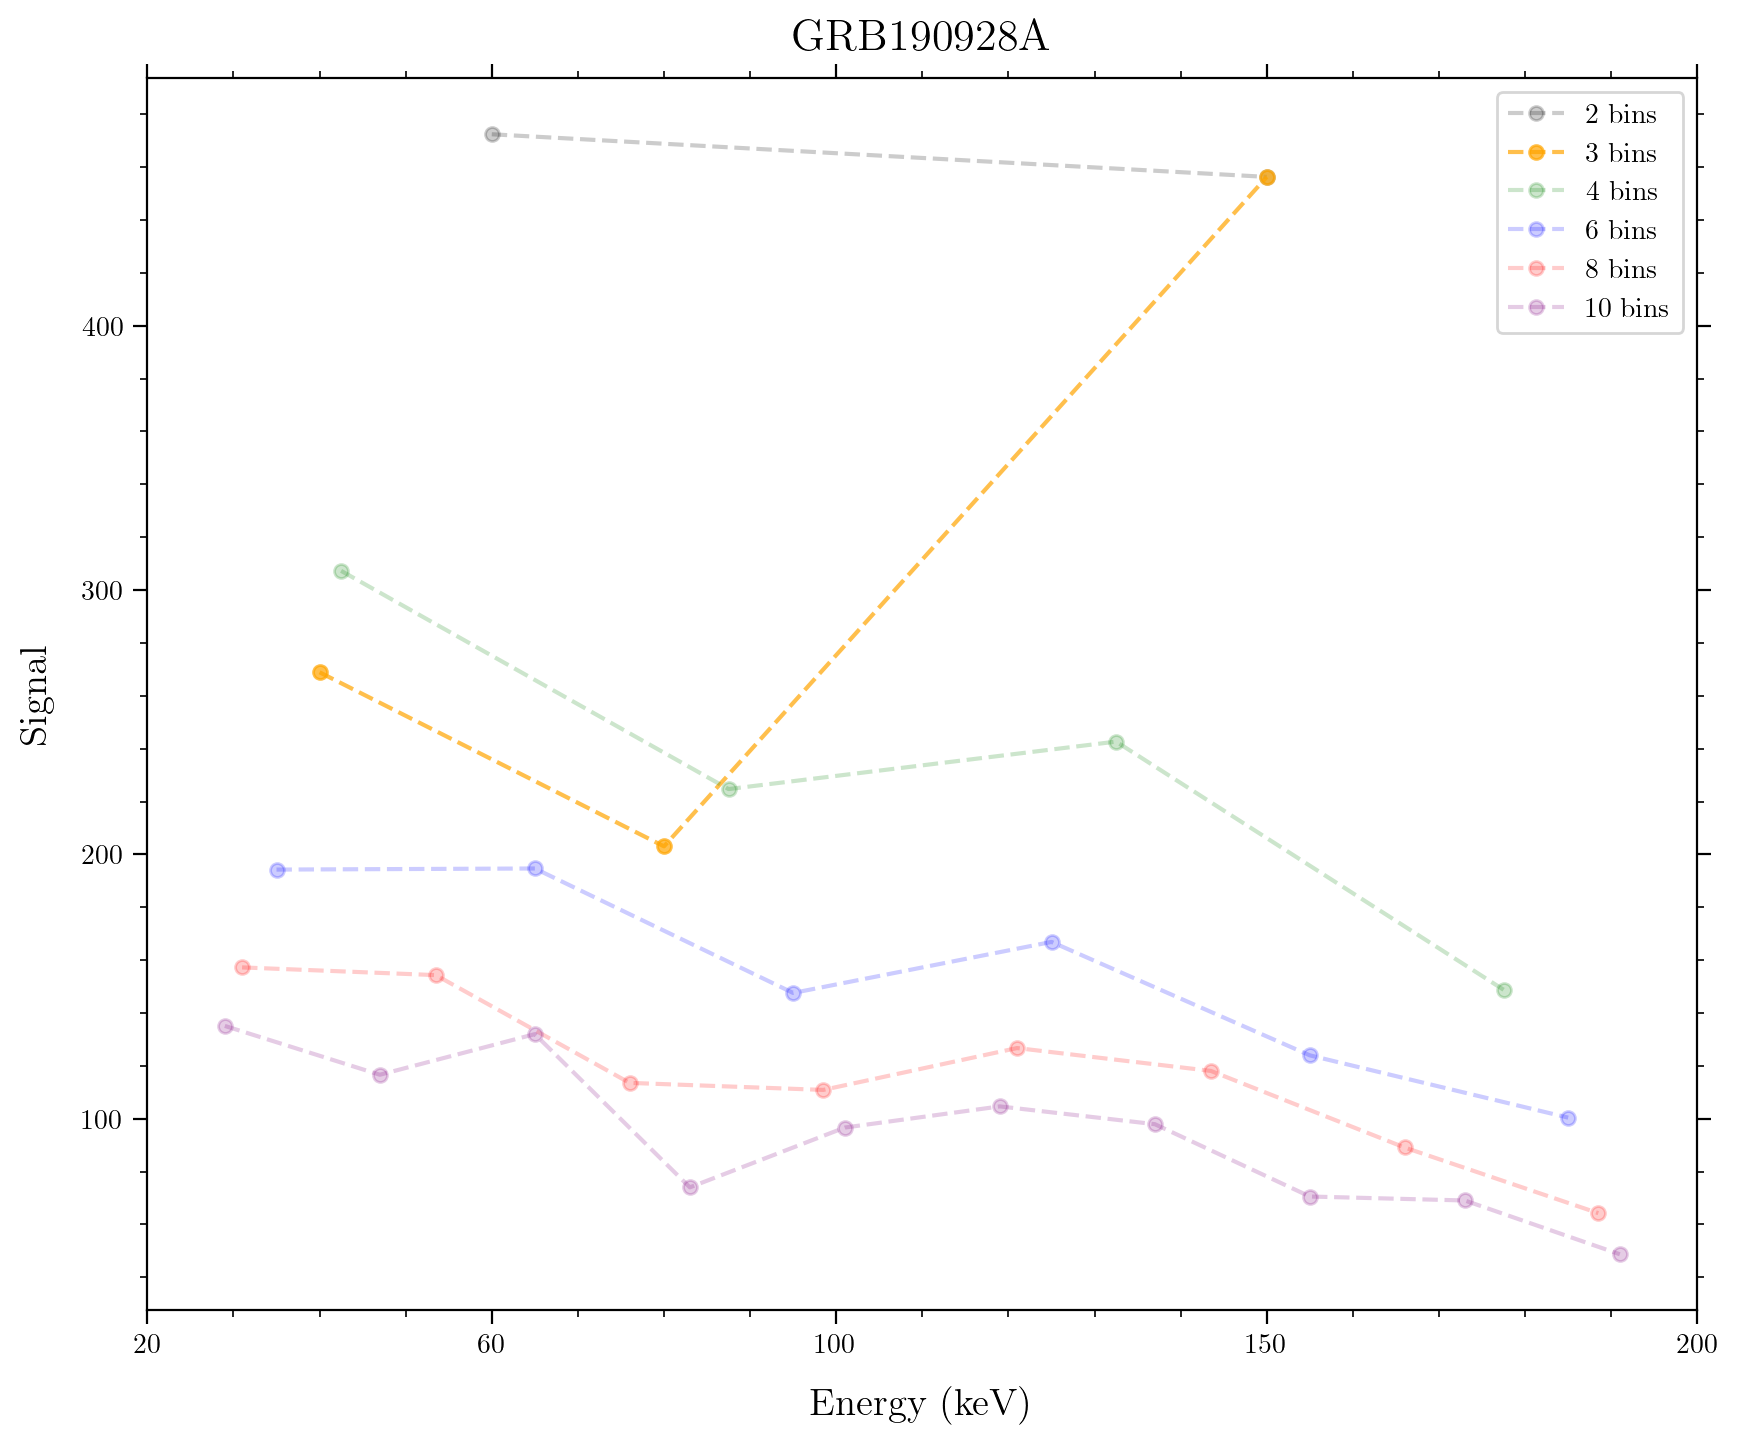

In [80]:
e_2 = np.array([60, 150])
e_3 = np.array([40, 80, 150])
e_4 = np.array([(20+65)/2, (65+110)/2, (110+155)/2, (155+200)/2])
e_6 = np.array([(20+50)/2, (50+80)/2, (80+110)/2, (110+140)/2, (140+170)/2, (170+200)/2])
e_8 = np.array([(20+42)/2, (42+65)/2, (65+87)/2, (87+110)/2, (110+132)/2, (132+155)/2, (155+177)/2, (177+200)/2])
e_10 = np.array([(20+38)/2, (38+56)/2, (56+74)/2, (74+92)/2, (92+110)/2, (110+128)/2, (128+146)/2, (146+164)/2, (164+182)/2, (182+200)/2])

snr_2bin_1 = snr_grb(lc_2bin_1, 1691, 1823)
snr_2bin_2 = snr_grb(lc_2bin_2, 1691, 1823)
snr_3bin_1 = snr_grb(lc_3bin_1, 1691, 1823)
snr_3bin_2 = snr_grb(lc_3bin_2, 1691, 1823)
snr_3bin_3 = snr_grb(lc_3bin_3, 1691, 1823)
snr_4bin_1 = snr_grb(lc_4bin_1, 1691, 1823)
snr_4bin_2 = snr_grb(lc_4bin_2, 1691, 1823)
snr_4bin_3 = snr_grb(lc_4bin_3, 1691, 1823)
snr_4bin_4 = snr_grb(lc_4bin_4, 1691, 1823)
snr_6bin_1 = snr_grb(lc_6bin_1, 1691, 1823)
snr_6bin_2 = snr_grb(lc_6bin_2, 1691, 1823)
snr_6bin_3 = snr_grb(lc_6bin_3, 1691, 1823)
snr_6bin_4 = snr_grb(lc_6bin_4, 1691, 1823)
snr_6bin_5 = snr_grb(lc_6bin_5, 1691, 1823)
snr_6bin_6 = snr_grb(lc_6bin_6, 1691, 1823)
snr_8bin_1 = snr_grb(lc_8bin_1, 1691, 1823)
snr_8bin_2 = snr_grb(lc_8bin_2, 1691, 1823)
snr_8bin_3 = snr_grb(lc_8bin_3, 1691, 1823)
snr_8bin_4 = snr_grb(lc_8bin_4, 1691, 1823)
snr_8bin_5 = snr_grb(lc_8bin_5, 1691, 1823)
snr_8bin_6 = snr_grb(lc_8bin_6, 1691, 1823)
snr_8bin_7 = snr_grb(lc_8bin_7, 1691, 1823)
snr_8bin_8 = snr_grb(lc_8bin_8, 1691, 1823)
snr_10bin_1 = snr_grb(lc_10bin_1, 1691, 1823)
snr_10bin_2 = snr_grb(lc_10bin_2, 1691, 1823)
snr_10bin_3 = snr_grb(lc_10bin_3, 1691, 1823)
snr_10bin_4 = snr_grb(lc_10bin_4, 1691, 1823)
snr_10bin_5 = snr_grb(lc_10bin_5, 1691, 1823)
snr_10bin_6 = snr_grb(lc_10bin_6, 1691, 1823)
snr_10bin_7 = snr_grb(lc_10bin_7, 1691, 1823)
snr_10bin_8 = snr_grb(lc_10bin_8, 1691, 1823)
snr_10bin_9 = snr_grb(lc_10bin_9, 1691, 1823)
snr_10bin_10 = snr_grb(lc_10bin_10, 1691, 1823)

signal_2bin = [snr_2bin_1[0], snr_2bin_2[0]]
noise_2bin = [snr_2bin_1[1], snr_2bin_2[1]]
snr_2bin = [snr_2bin_1[2], snr_2bin_2[2]]
signal_3bin = [snr_3bin_1[0], snr_3bin_2[0], snr_3bin_3[0]]
noise_3bin = [snr_3bin_1[1], snr_3bin_2[1], snr_3bin_3[1]]
snr_3bin = [snr_3bin_1[2], snr_3bin_2[2], snr_3bin_3[2]]
signal_4bin = [snr_4bin_1[0], snr_4bin_2[0], snr_4bin_3[0], snr_4bin_4[0]]
noise_4bin = [snr_4bin_1[1], snr_4bin_2[1], snr_4bin_3[1], snr_4bin_4[1]]
snr_4bin = [snr_4bin_1[2], snr_4bin_2[2], snr_4bin_3[2], snr_4bin_4[2]]
signal_6bin = [snr_6bin_1[0], snr_6bin_2[0], snr_6bin_3[0], snr_6bin_4[0], snr_6bin_5[0], snr_6bin_6[0]]
noise_6bin = [snr_6bin_1[1], snr_6bin_2[1], snr_6bin_3[1], snr_6bin_4[1], snr_6bin_5[1], snr_6bin_6[1]]
snr_6bin = [snr_6bin_1[2], snr_6bin_2[2], snr_6bin_3[2], snr_6bin_4[2], snr_6bin_5[2], snr_6bin_6[2]]
signal_8bin = [snr_8bin_1[0], snr_8bin_2[0], snr_8bin_3[0], snr_8bin_4[0], snr_8bin_5[0], snr_8bin_6[0], snr_8bin_7[0], snr_8bin_8[0]]
noise_8bin = [snr_8bin_1[1], snr_8bin_2[1], snr_8bin_3[1], snr_8bin_4[1], snr_8bin_5[1], snr_8bin_6[1], snr_8bin_7[1], snr_8bin_8[1]]
snr_8bin = [snr_8bin_1[2], snr_8bin_2[2], snr_8bin_3[2], snr_8bin_4[2], snr_8bin_5[2], snr_8bin_6[2], snr_8bin_7[2], snr_8bin_8[2]]
signal_10bin = [snr_10bin_1[0], snr_10bin_2[0], snr_10bin_3[0], snr_10bin_4[0], snr_10bin_5[0], snr_10bin_6[0], snr_10bin_7[0], snr_10bin_8[0], snr_10bin_9[0], snr_10bin_10[0]]
noise_10bin = [snr_10bin_1[1], snr_10bin_2[1], snr_10bin_3[1], snr_10bin_4[1], snr_10bin_5[1], snr_10bin_6[1], snr_10bin_7[1], snr_10bin_8[1], snr_10bin_9[1], snr_10bin_10[1]]
snr_10bin = [snr_10bin_1[2], snr_10bin_2[2], snr_10bin_3[2], snr_10bin_4[2], snr_10bin_5[2], snr_10bin_6[2], snr_10bin_7[2], snr_10bin_8[2], snr_10bin_9[2], snr_10bin_10[2]]

plt.figure(figsize=(10, 8), dpi=200)
plt.plot(e_2, signal_2bin, color='black', marker='o', markersize=5, alpha=0.2, label="2 bins", linestyle='--')
plt.plot(e_3, signal_3bin, color='orange', marker='o', markersize=5, alpha=0.7, label="3 bins", linestyle='--')
plt.plot(e_4, signal_4bin, color='green', marker='o', markersize=5, alpha=0.2, label="4 bins", linestyle='--')
plt.plot(e_6, signal_6bin, color='blue', marker='o', markersize=5, alpha=0.2, label="6 bins", linestyle='--')
plt.plot(e_8, signal_8bin, color='red', marker='o', markersize=5, alpha=0.2,  label="8 bins", linestyle='--')
plt.plot(e_10, signal_10bin, color='purple', marker='o', markersize=5, alpha=0.2,   label="10 bins", linestyle='--')
plt.xticks([20, 60, 100, 150, 200])
plt.legend(loc='upper right')
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("Signal", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.show()

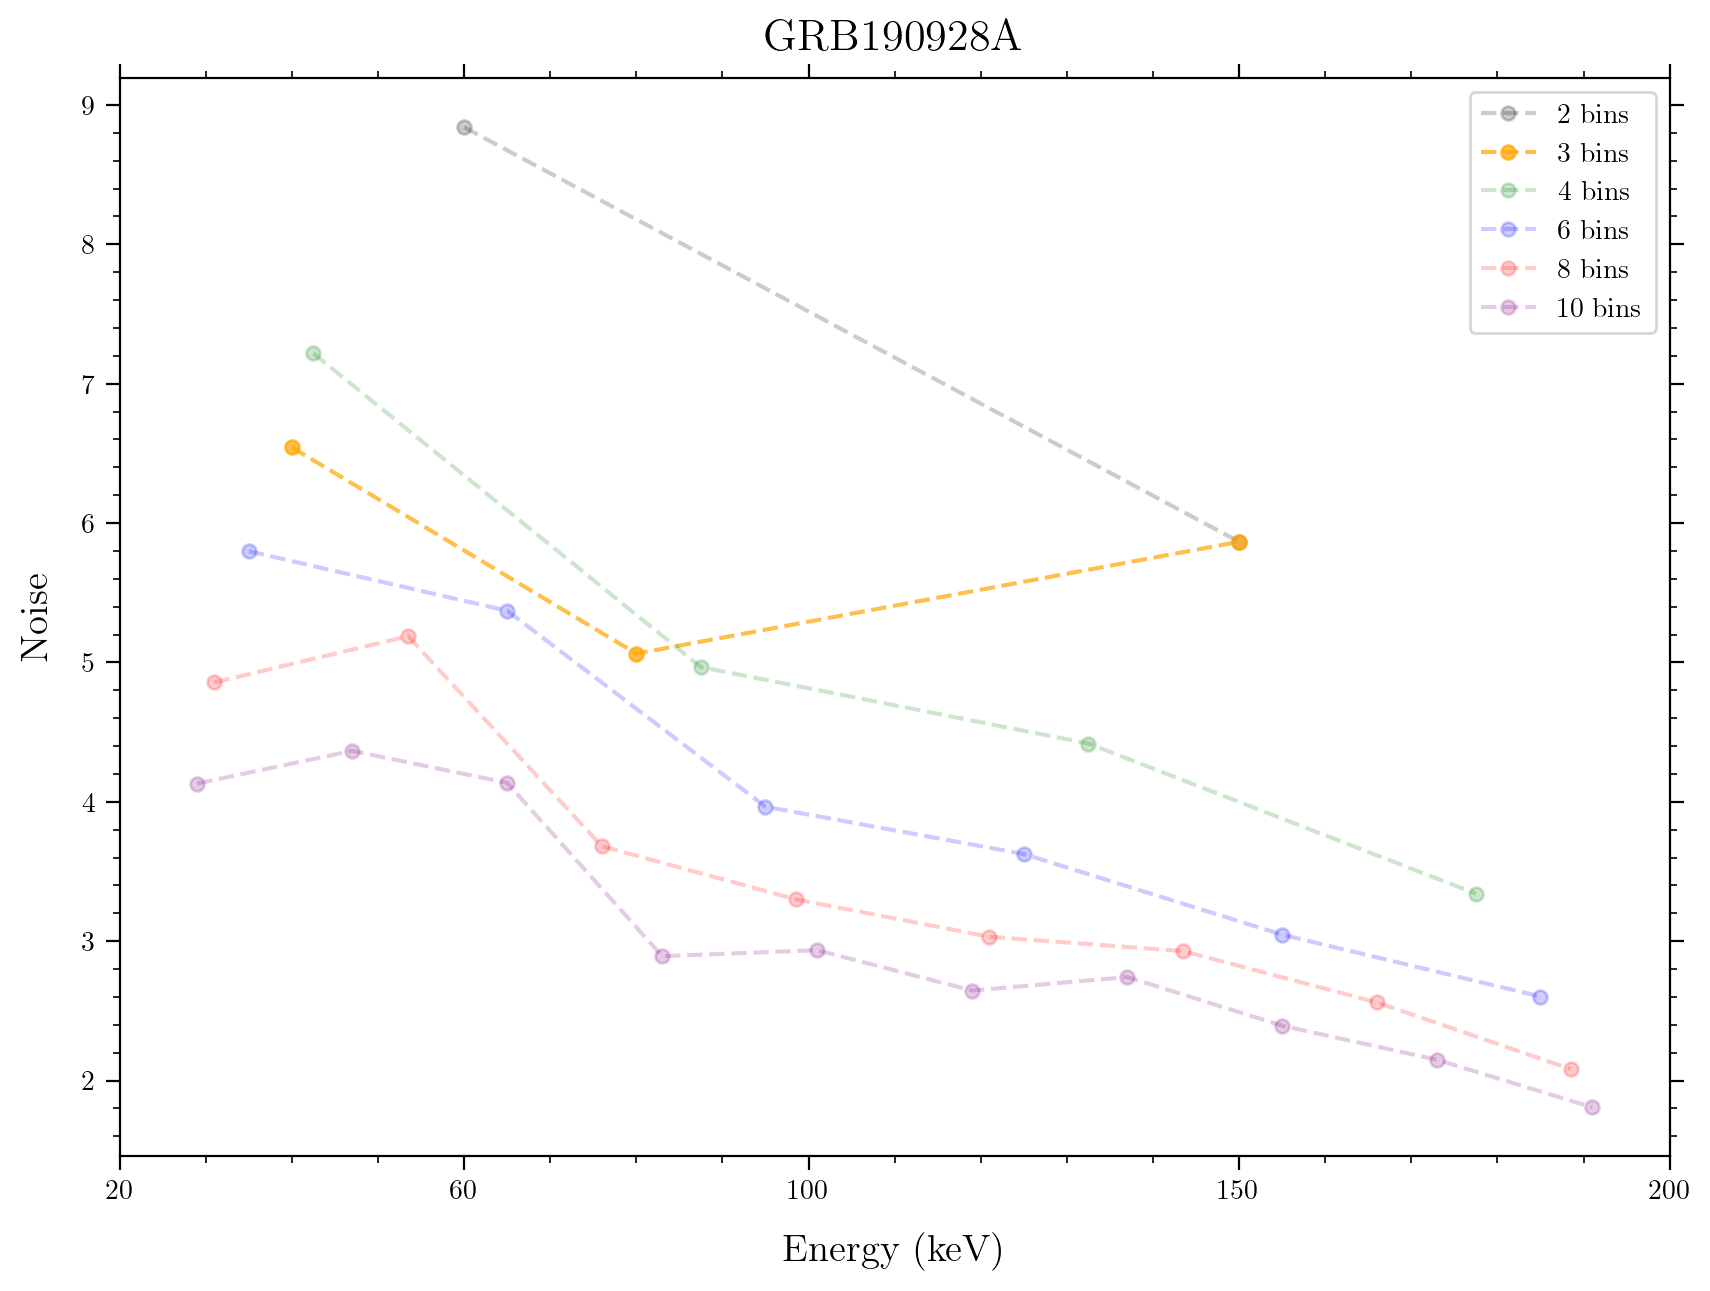

In [81]:
plt.figure(figsize=(10, 7), dpi=200)
plt.plot(e_2, noise_2bin, color='black', marker='o', markersize=5, alpha=0.2, label="2 bins", linestyle='--')
plt.plot(e_3, noise_3bin, color='orange', marker='o', markersize=5, alpha=0.7, label="3 bins", linestyle='--')
plt.plot(e_4, noise_4bin, color='green', marker='o', markersize=5, alpha=0.2, label="4 bins", linestyle='--')
plt.plot(e_6, noise_6bin, color='blue', marker='o', markersize=5, alpha=0.2, label="6 bins", linestyle='--')
plt.plot(e_8, noise_8bin, color='red', marker='o', markersize=5, alpha=0.2,  label="8 bins", linestyle='--')
plt.plot(e_10, noise_10bin, color='purple', marker='o', markersize=5, alpha=0.2,   label="10 bins", linestyle='--')
plt.xticks([20, 60, 100, 150, 200])
plt.legend(loc='upper right')
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("Noise", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.show()

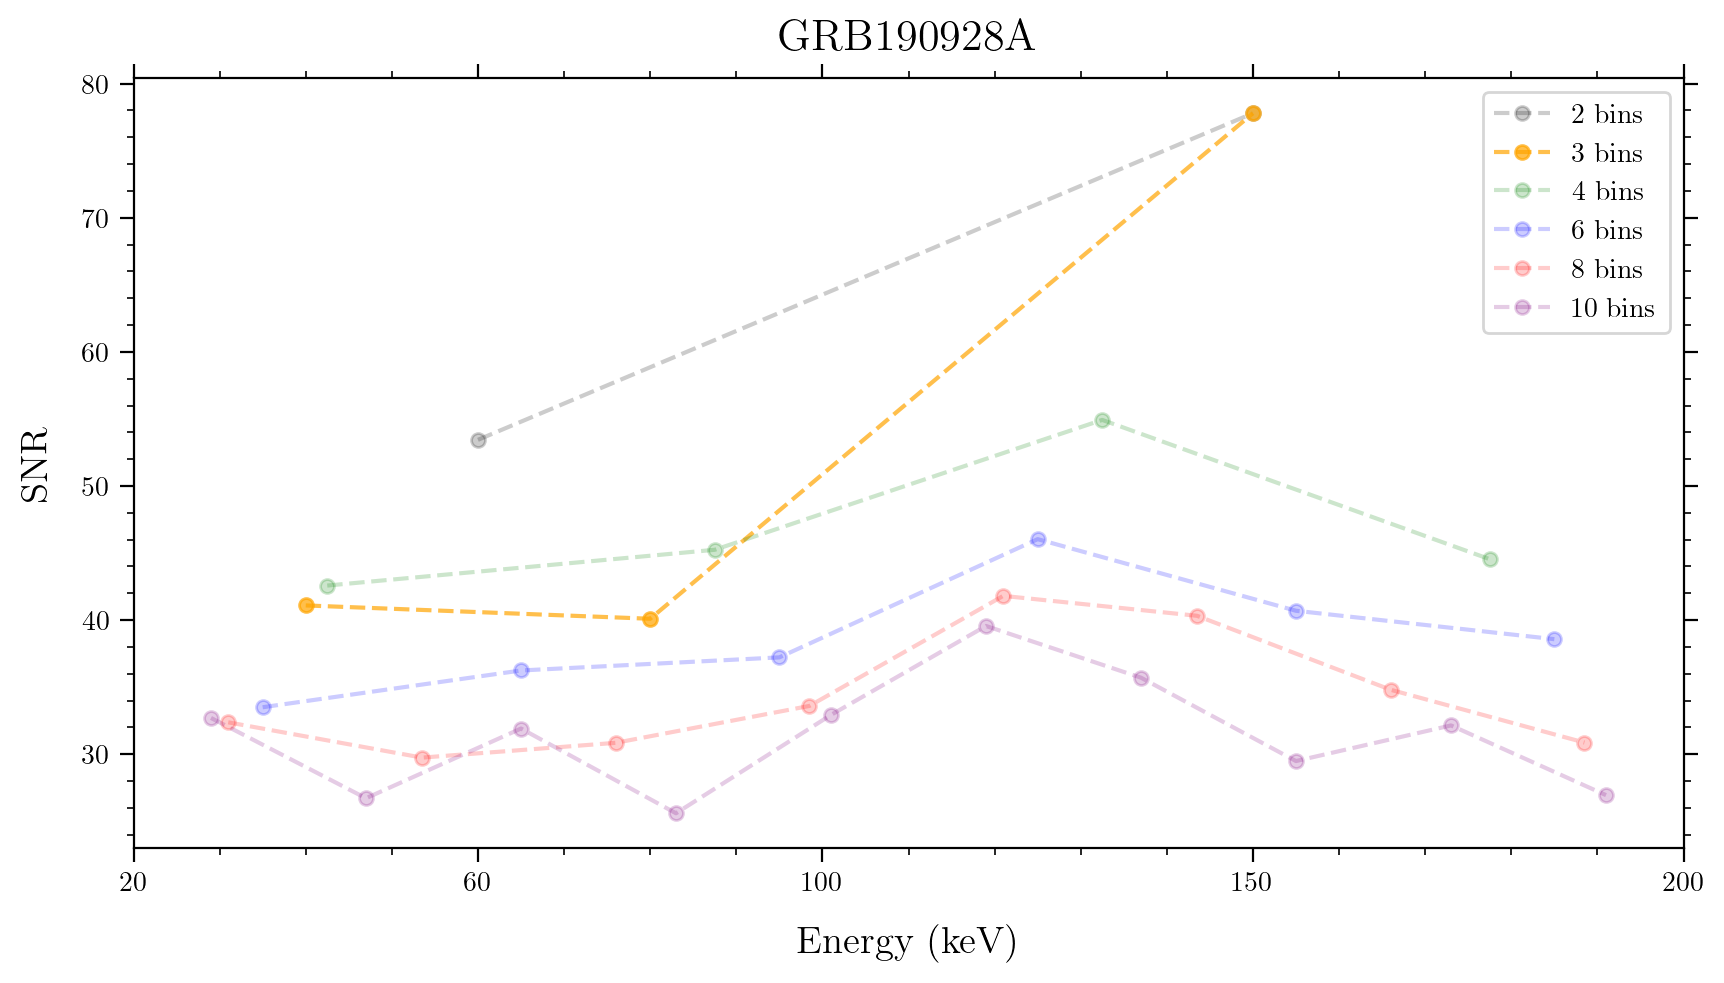

In [79]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(e_2, snr_2bin, color='black', marker='o', markersize=5, alpha=0.2, label="2 bins", linestyle='--')
plt.plot(e_3, snr_3bin, color='orange', marker='o', markersize=5, alpha=0.7, label="3 bins", linestyle='--')
plt.plot(e_4, snr_4bin, color='green', marker='o', markersize=5, alpha=0.2, label="4 bins", linestyle='--')
plt.plot(e_6, snr_6bin, color='blue', marker='o', markersize=5, alpha=0.2, label="6 bins", linestyle='--')
plt.plot(e_8, snr_8bin, color='red', marker='o', markersize=5, alpha=0.2,  label="8 bins", linestyle='--')
plt.plot(e_10, snr_10bin, color='purple', marker='o', markersize=5, alpha=0.2,   label="10 bins", linestyle='--')
plt.xticks([20, 60, 100, 150, 200])
plt.legend(loc='upper right')
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("SNR", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.show()

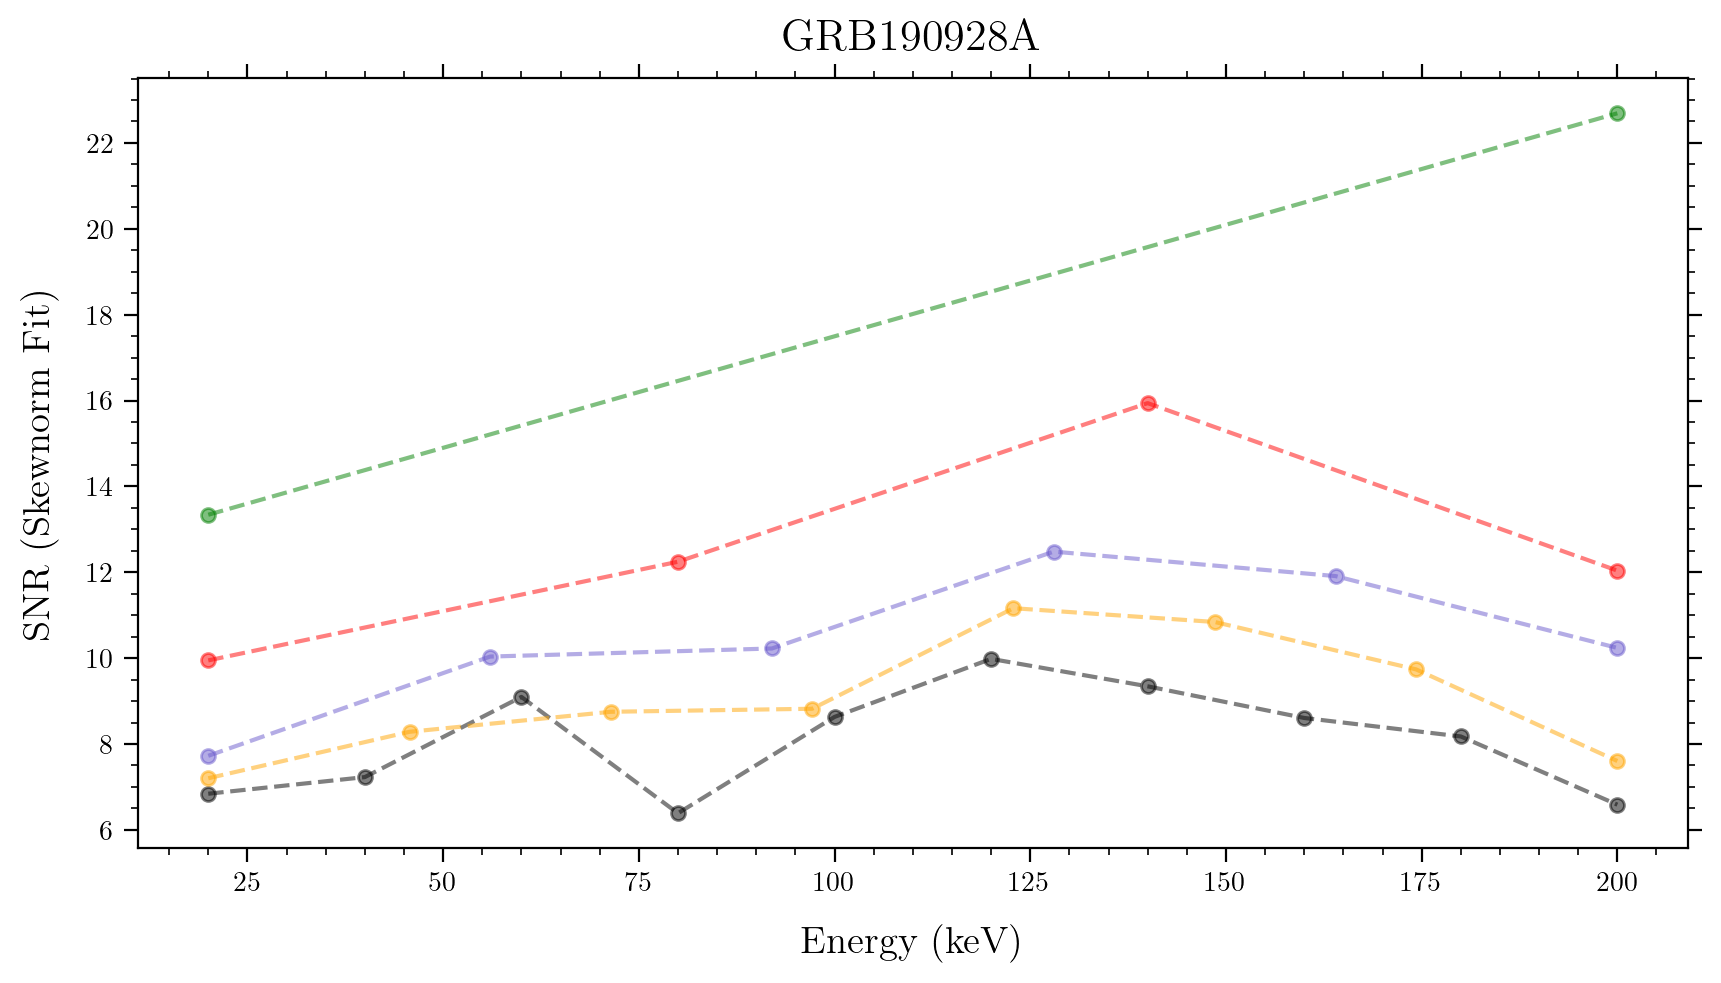

In [52]:
x_10 = np.linspace(20, 200, 10)
x_8 = np.linspace(20, 200, 8)
x_6 = np.linspace(20, 200, 6)
x_4 = np.linspace(20, 200, 4)
x_2 = np.linspace(20, 200, 2)

snr_2bin_skewnorm = np.array([snr_2bin_1_skewnorm, snr_2bin_2_skewnorm])
snr_4bin_skewnorm = np.array([snr_4bin_1_skewnorm, snr_4bin_2_skewnorm, snr_4bin_3_skewnorm, snr_4bin_4_skewnorm])
snr_6bin_skewnorm = np.array([snr_6bin_1_skewnorm, snr_6bin_2_skewnorm, snr_6bin_3_skewnorm, snr_6bin_4_skewnorm, snr_6bin_5_skewnorm, snr_6bin_6_skewnorm])
snr_8bin_skewnorm = np.array([snr_8bin_1_skewnorm, snr_8bin_2_skewnorm, snr_8bin_3_skewnorm, snr_8bin_4_skewnorm, snr_8bin_5_skewnorm, snr_8bin_6_skewnorm, snr_8bin_7_skewnorm, snr_8bin_8_skewnorm])
snr_10bin_skewnorm = np.array([snr_10bin_1_skewnorm, snr_10bin_2_skewnorm, snr_10bin_3_skewnorm, snr_10bin_4_skewnorm, snr_10bin_5_skewnorm, snr_10bin_6_skewnorm, snr_10bin_7_skewnorm, snr_10bin_8_skewnorm, snr_10bin_9_skewnorm, snr_10bin_10_skewnorm])
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_10, snr_10bin_skewnorm, color='black', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_8, snr_8bin_skewnorm, color='orange', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_6, snr_6bin_skewnorm, color='slateblue', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_4, snr_4bin_skewnorm, color='red', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_2, snr_2bin_skewnorm, color='green', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("SNR (Skewnorm Fit)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.show()

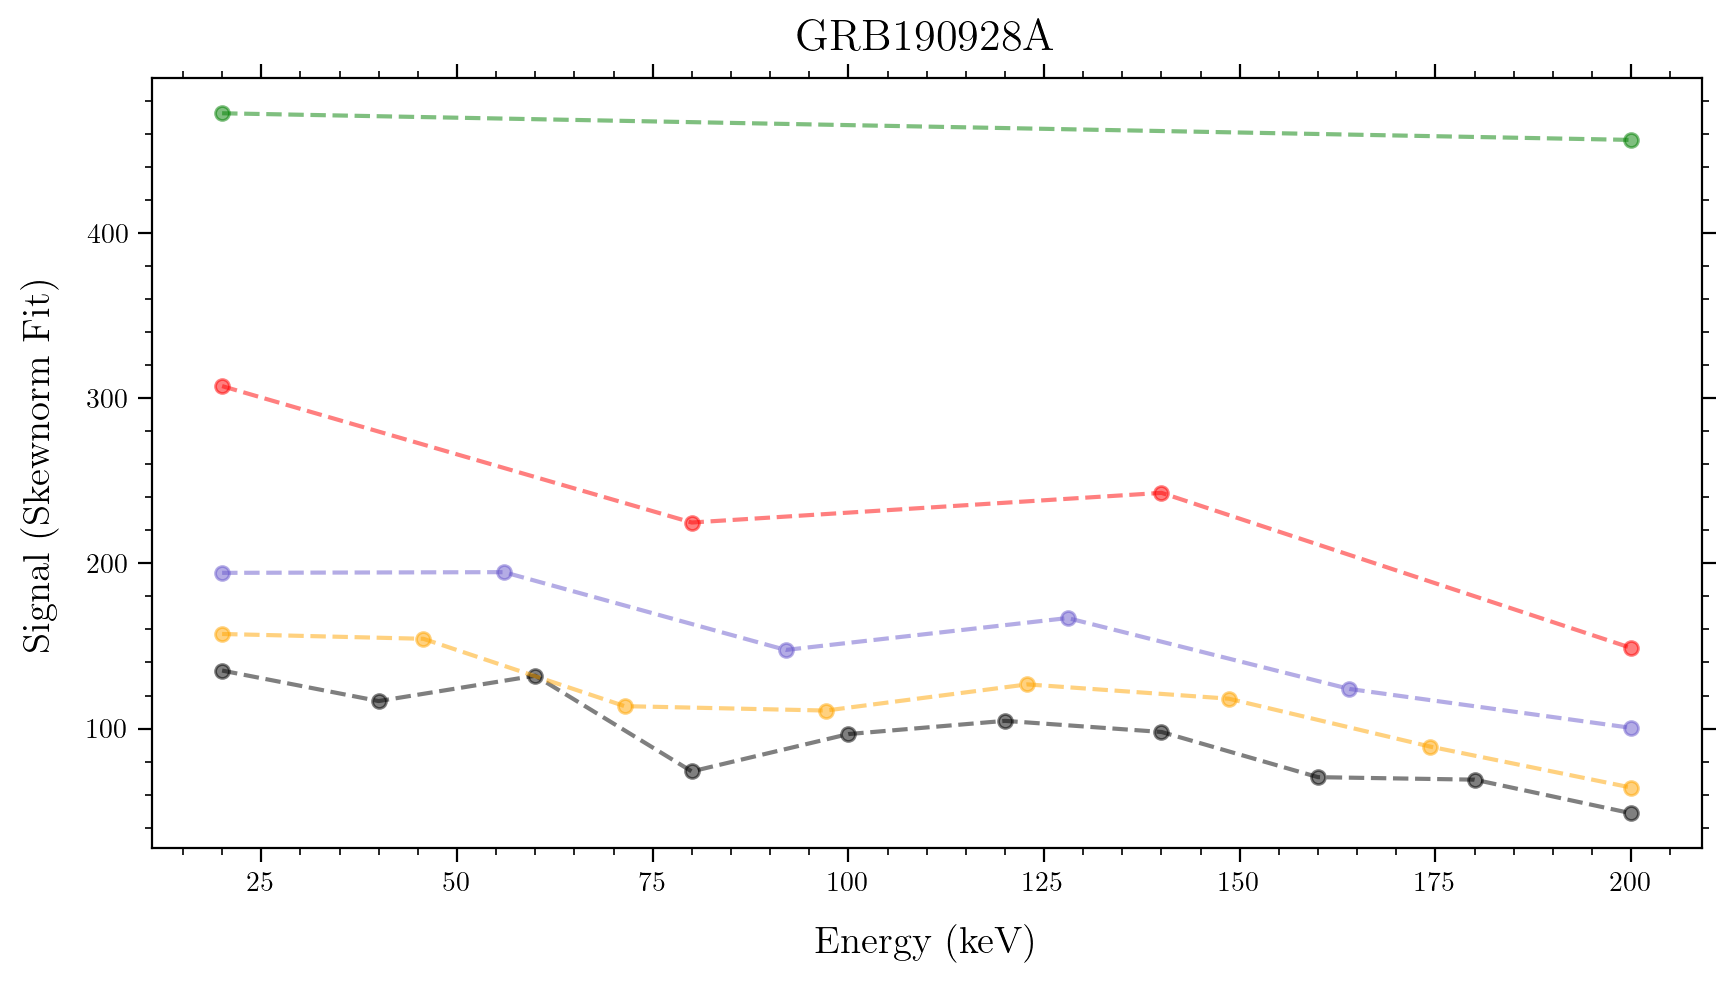

In [53]:
signal_10bin = np.array([max(t_10bin_1['RATE']), max(t_10bin_2['RATE']), max(t_10bin_3['RATE']), max(t_10bin_4['RATE']), max(t_10bin_5['RATE']), max(t_10bin_6['RATE']), max(t_10bin_7['RATE']), max(t_10bin_8['RATE']), max(t_10bin_9['RATE']), max(t_10bin_10['RATE'])])
signal_8bin = np.array([max(t_8bin_1['RATE']), max(t_8bin_2['RATE']), max(t_8bin_3['RATE']), max(t_8bin_4['RATE']), max(t_8bin_5['RATE']), max(t_8bin_6['RATE']), max(t_8bin_7['RATE']), max(t_8bin_8['RATE'])])
signal_6bin = np.array([max(t_6bin_1['RATE']), max(t_6bin_2['RATE']), max(t_6bin_3['RATE']), max(t_6bin_4['RATE']), max(t_6bin_5['RATE']), max(t_6bin_6['RATE'])])
signal_4bin = np.array([max(t_4bin_1['RATE']), max(t_4bin_2['RATE']), max(t_4bin_3['RATE']), max(t_4bin_4['RATE'])])
signal_2bin = np.array([max(t_2bin_1['RATE']), max(t_2bin_2['RATE'])])
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_10, signal_10bin, color='black', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_8, signal_8bin, color='orange', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_6, signal_6bin, color='slateblue', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_4, signal_4bin, color='red', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_2, signal_2bin, color='green', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("Signal (Skewnorm Fit)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.show()

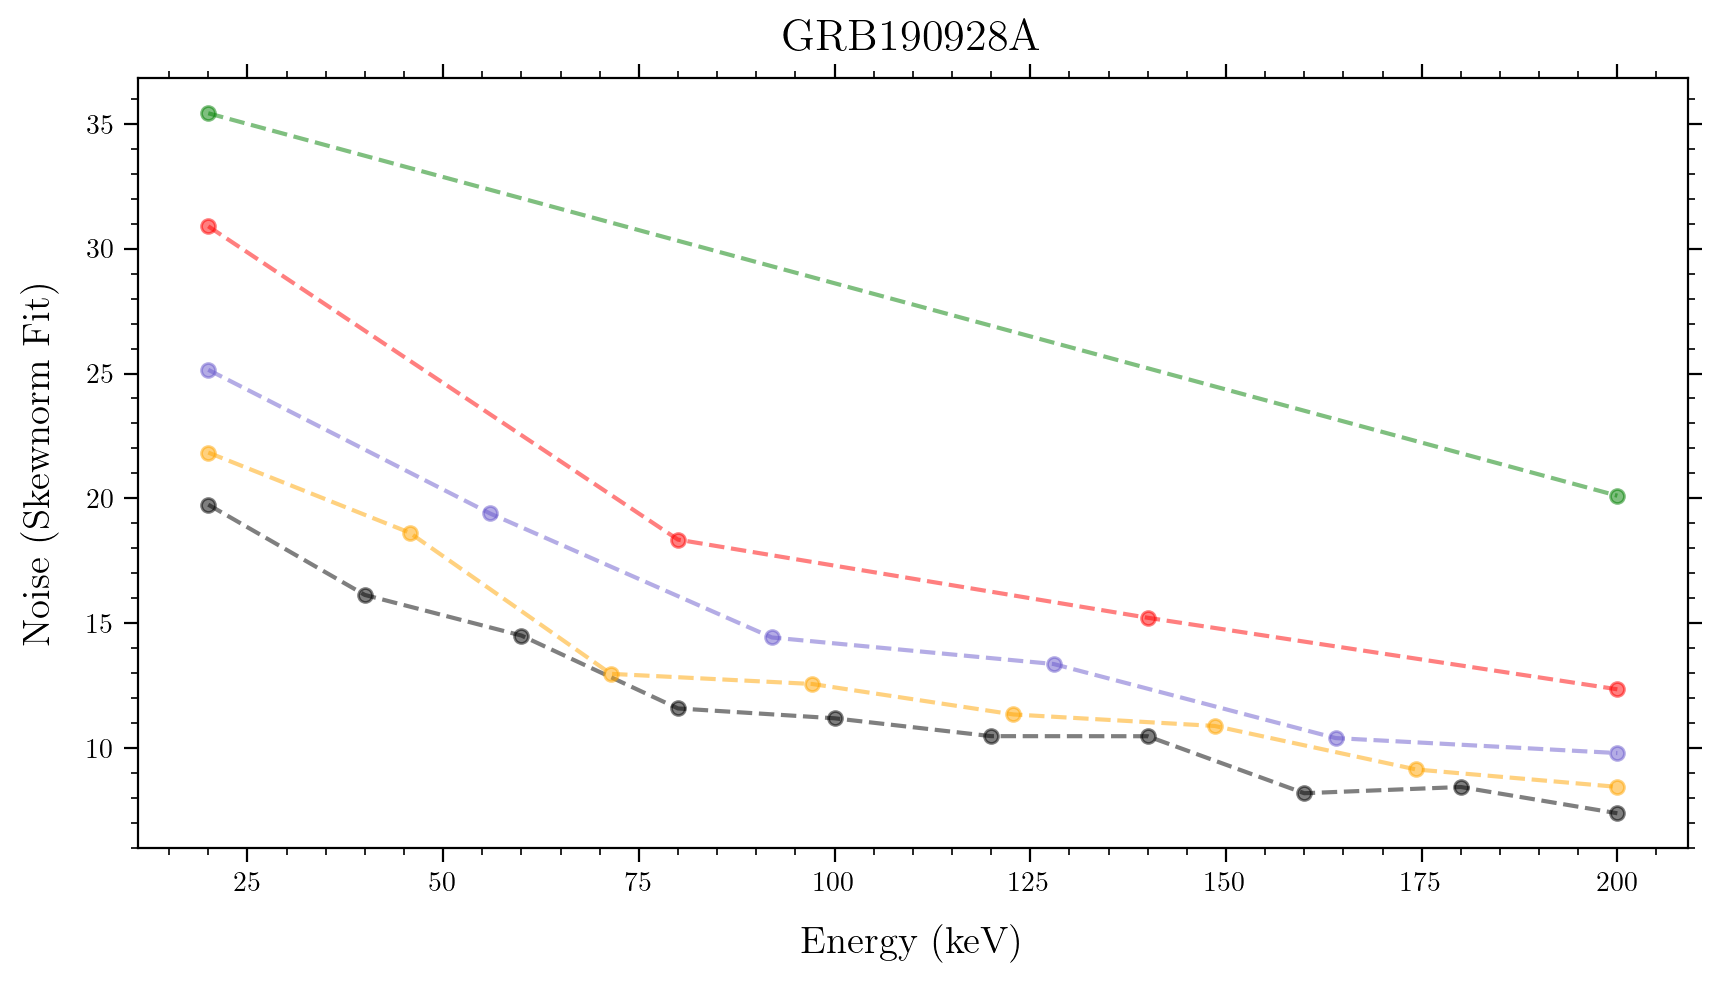

In [54]:
noise_10bin = np.array([signal_10bin[0]/snr_10bin_1_skewnorm, signal_10bin[1]/snr_10bin_2_skewnorm, signal_10bin[2]/snr_10bin_3_skewnorm, signal_10bin[3]/snr_10bin_4_skewnorm, signal_10bin[4]/snr_10bin_5_skewnorm, signal_10bin[5]/snr_10bin_6_skewnorm, signal_10bin[6]/snr_10bin_7_skewnorm, signal_10bin[7]/snr_10bin_8_skewnorm, signal_10bin[8]/snr_10bin_9_skewnorm, signal_10bin[9]/snr_10bin_10_skewnorm])
noise_8bin = np.array([signal_8bin[0]/snr_8bin_1_skewnorm, signal_8bin[1]/snr_8bin_2_skewnorm, signal_8bin[2]/snr_8bin_3_skewnorm, signal_8bin[3]/snr_8bin_4_skewnorm, signal_8bin[4]/snr_8bin_5_skewnorm, signal_8bin[5]/snr_8bin_6_skewnorm, signal_8bin[6]/snr_8bin_7_skewnorm, signal_8bin[7]/snr_8bin_8_skewnorm])
noise_6bin = np.array([signal_6bin[0]/snr_6bin_1_skewnorm, signal_6bin[1]/snr_6bin_2_skewnorm, signal_6bin[2]/snr_6bin_3_skewnorm, signal_6bin[3]/snr_6bin_4_skewnorm, signal_6bin[4]/snr_6bin_5_skewnorm, signal_6bin[5]/snr_6bin_6_skewnorm])
noise_4bin = np.array([signal_4bin[0]/snr_4bin_1_skewnorm, signal_4bin[1]/snr_4bin_2_skewnorm, signal_4bin[2]/snr_4bin_3_skewnorm, signal_4bin[3]/snr_4bin_4_skewnorm])
noise_2bin = np.array([signal_2bin[0]/snr_2bin_1_skewnorm, signal_2bin[1]/snr_2bin_2_skewnorm])
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_10, noise_10bin, color='black', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_8, noise_8bin, color='orange', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_6, noise_6bin, color='slateblue', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_4, noise_4bin, color='red', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_2, noise_2bin, color='green', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("Noise (Skewnorm Fit)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.show()

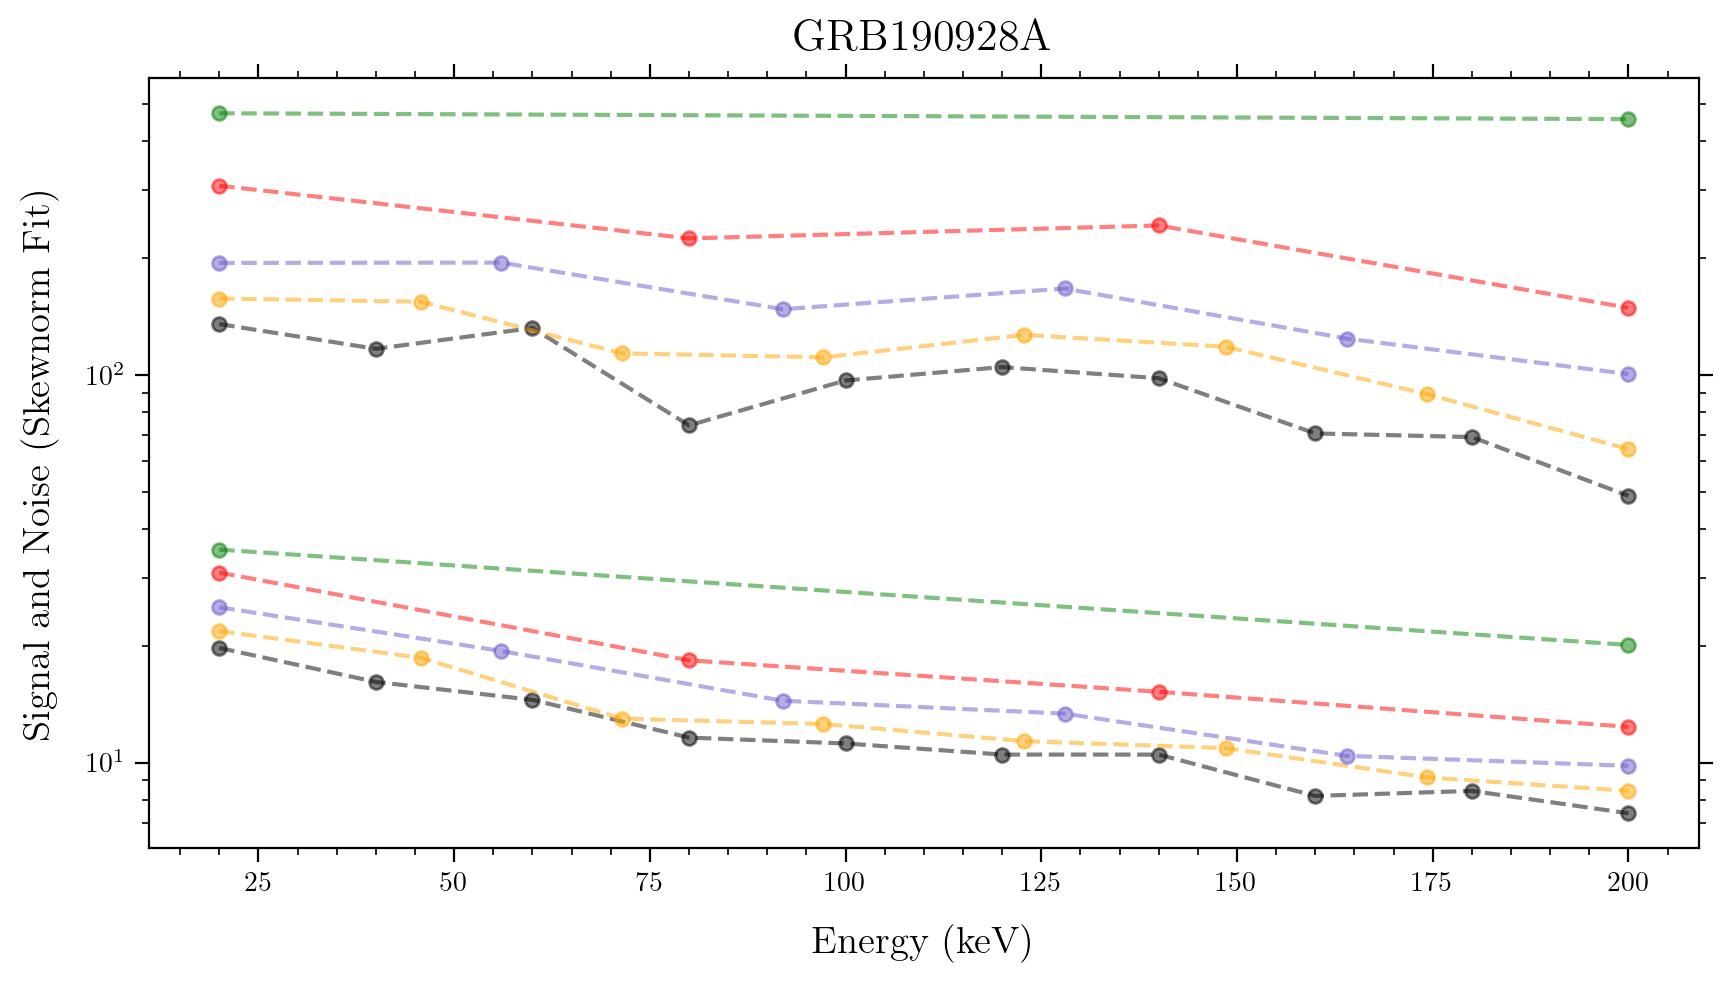

In [55]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_10, signal_10bin, color='black', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_10, noise_10bin, color='black', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_8, signal_8bin, color='orange', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_8, noise_8bin, color='orange', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_6, signal_6bin, color='slateblue', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_6, noise_6bin, color='slateblue', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_4, signal_4bin, color='red', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_4, noise_4bin, color='red', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_2, signal_2bin, color='green', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.plot(x_2, noise_2bin, color='green', marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("Signal and Noise (Skewnorm Fit)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.yscale('log')
plt.show()

In [56]:
snr_2bin_outlier = np.array([snr_2bin_1_outlier, snr_2bin_2_outlier])
snr_4bin_outlier = np.array([snr_4bin_1_outlier, snr_4bin_2_outlier, snr_4bin_3_outlier, snr_4bin_4_outlier])
snr_6bin_outlier = np.array([snr_6bin_1_outlier, snr_6bin_2_outlier, snr_6bin_3_outlier, snr_6bin_4_outlier, snr_6bin_5_outlier, snr_6bin_6_outlier])
snr_8bin_outlier = np.array([snr_8bin_1_outlier, snr_8bin_2_outlier, snr_8bin_3_outlier, snr_8bin_4_outlier, snr_8bin_5_outlier, snr_8bin_6_outlier, snr_8bin_7_outlier, snr_8bin_8_outlier])
snr_10bin_outlier = np.array([snr_10bin_1_outlier, snr_10bin_2_outlier, snr_10bin_3_outlier, snr_10bin_4_outlier, snr_10bin_5_outlier, snr_10bin_6_outlier, snr_10bin_7_outlier, snr_10bin_8_outlier, snr_10bin_9_outlier, snr_10bin_10_outlier])

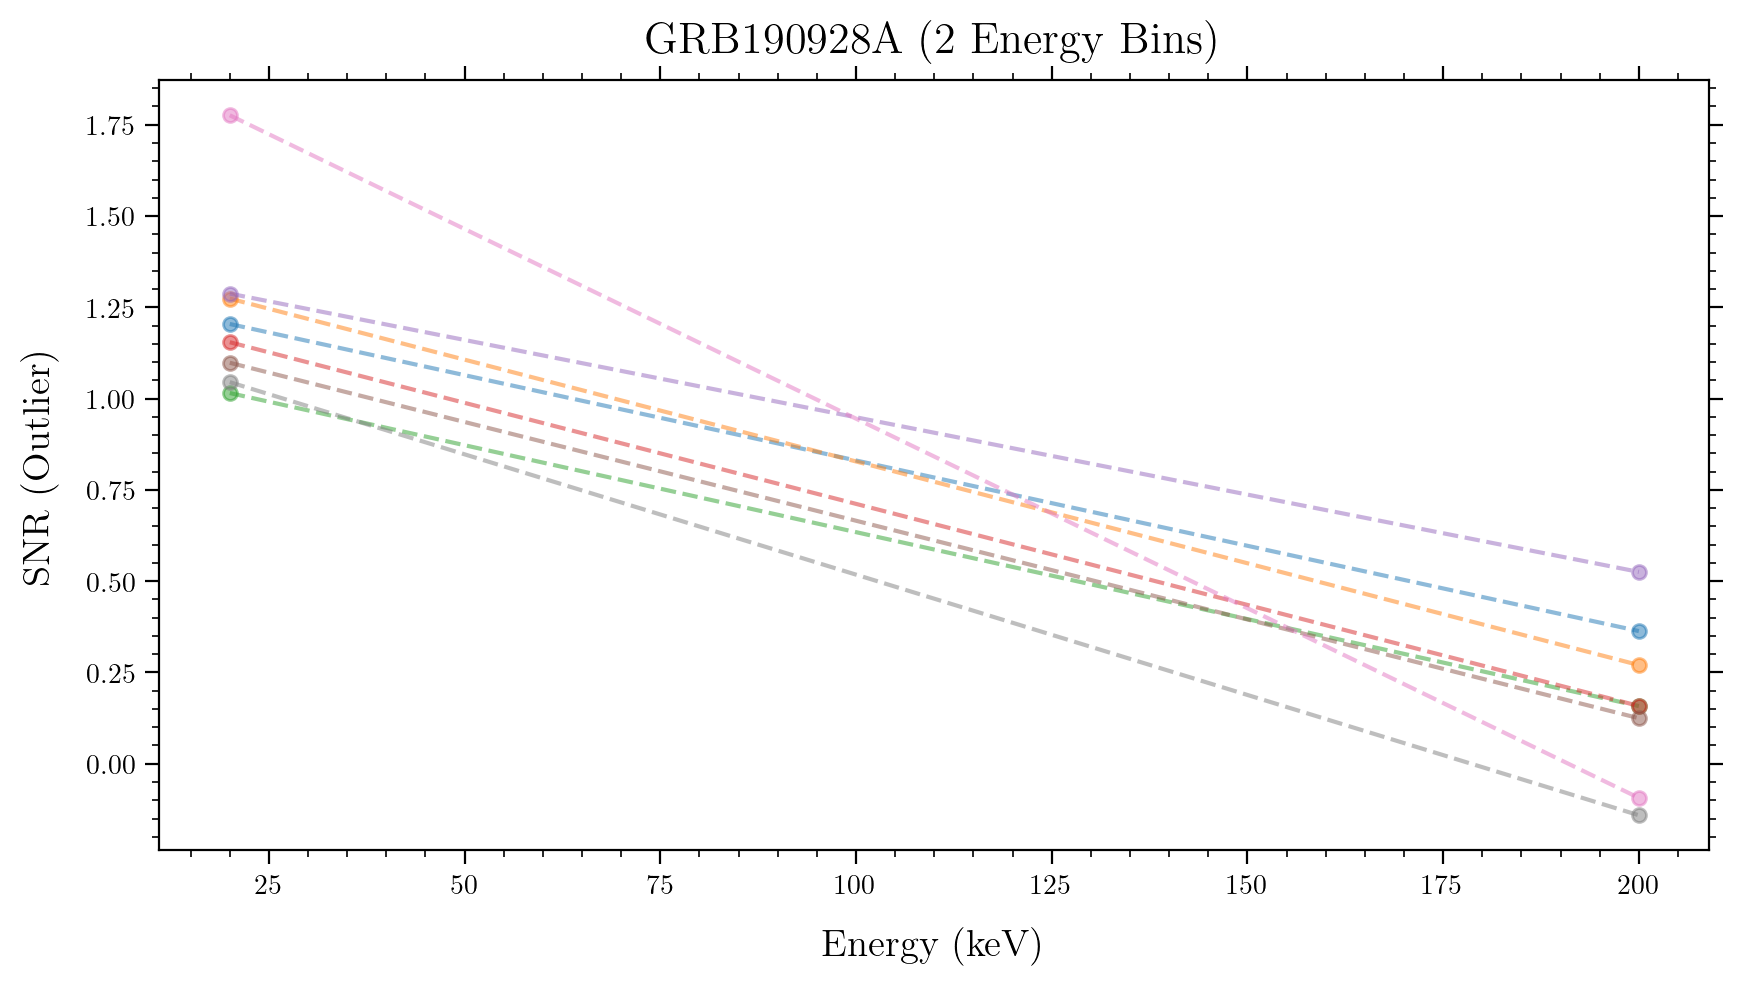

In [57]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_2, snr_2bin_outlier, marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("SNR (Outlier)", labelpad=10, fontsize=14)
plt.title("GRB190928A (2 Energy Bins)", pad=10, fontsize=16)
plt.show()

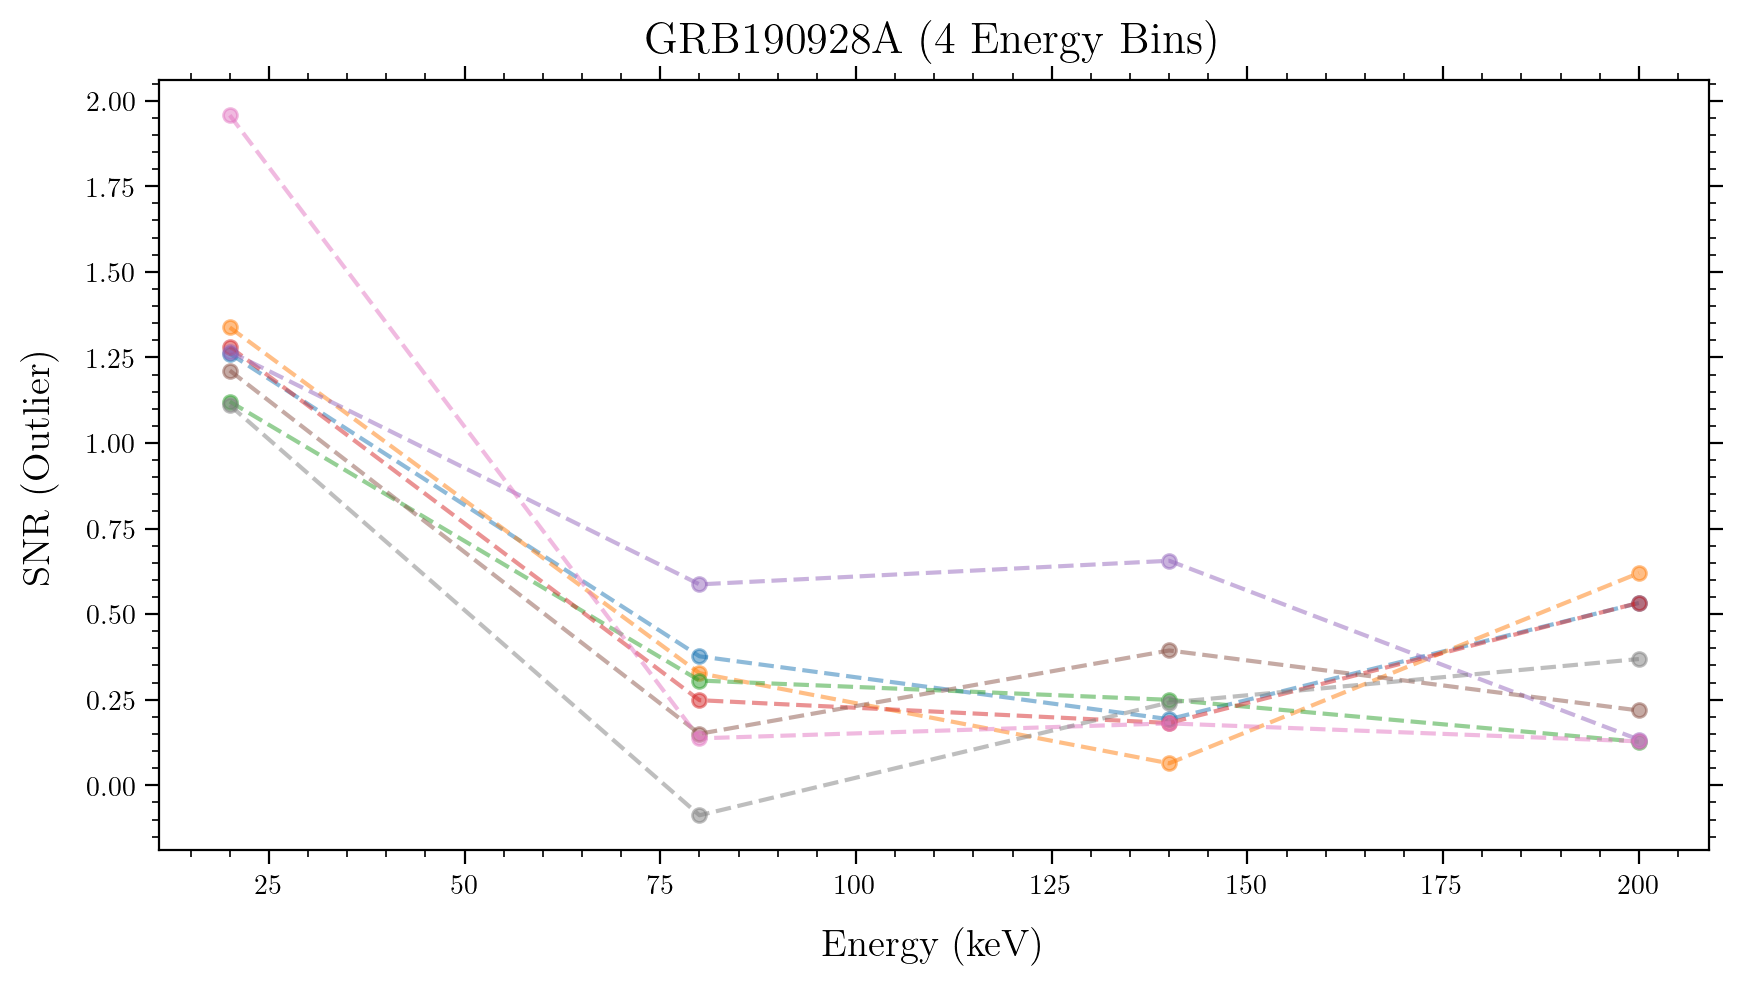

In [58]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_4, snr_4bin_outlier, marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("SNR (Outlier)", labelpad=10, fontsize=14)
plt.title("GRB190928A (4 Energy Bins)", pad=10, fontsize=16)
plt.show()

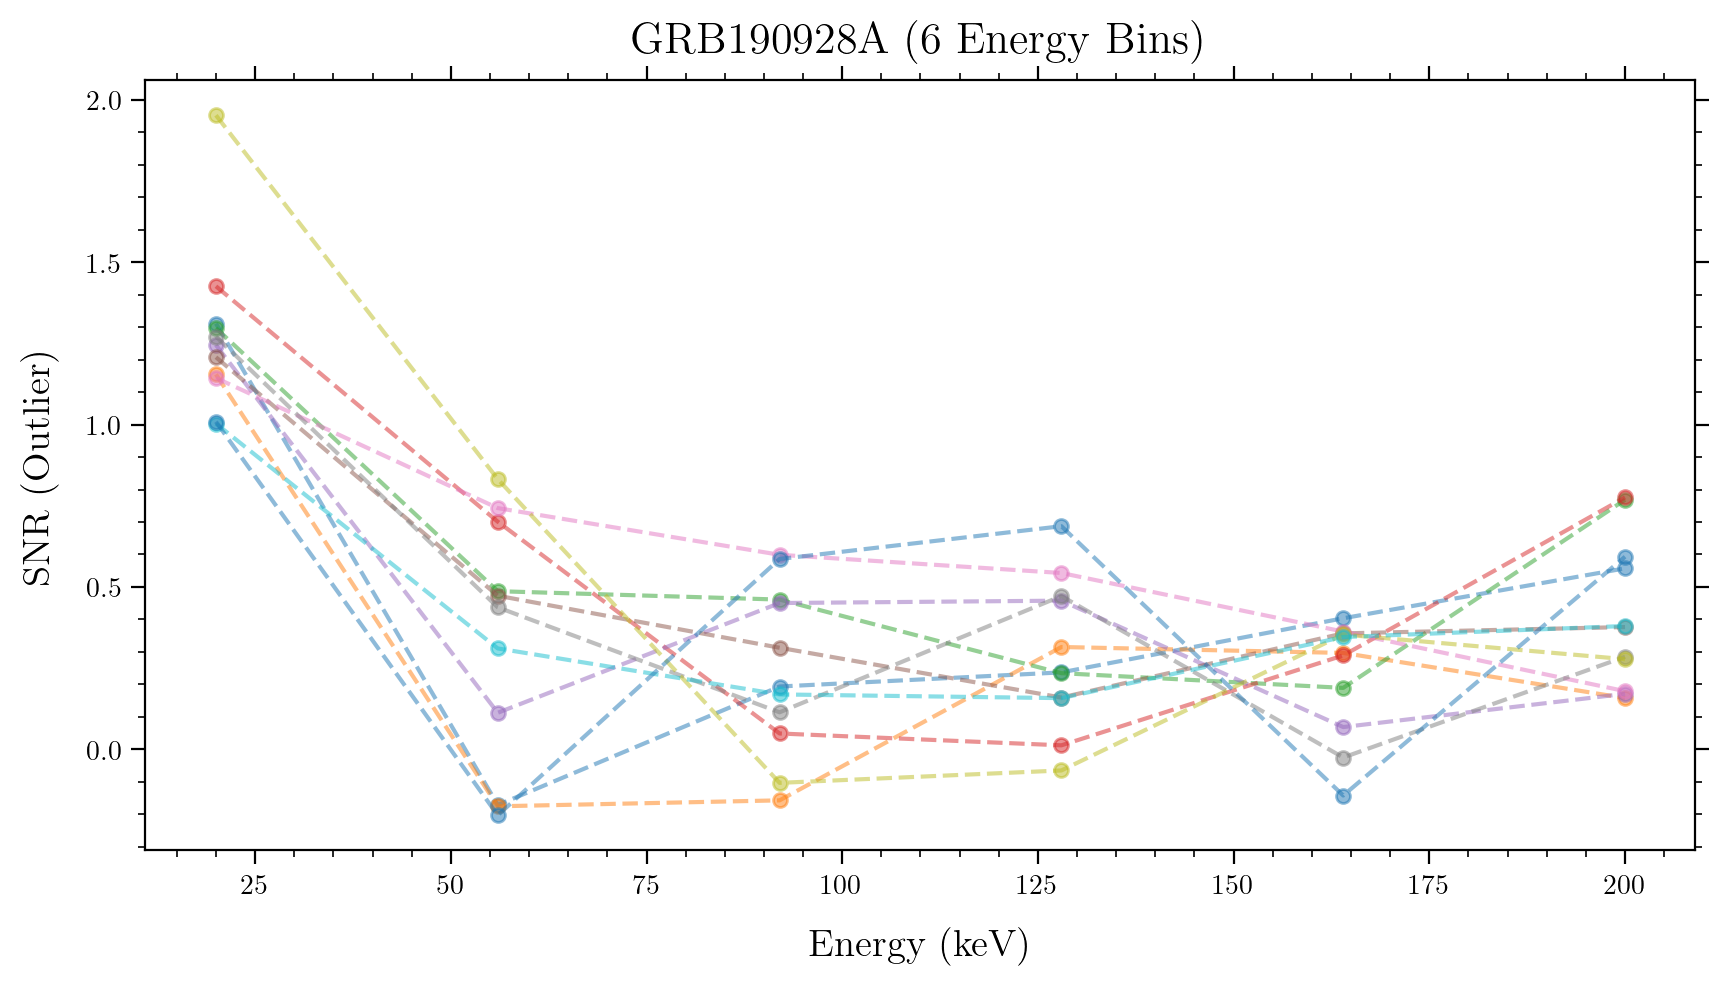

In [59]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_6, snr_6bin_outlier, marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("SNR (Outlier)", labelpad=10, fontsize=14)
plt.title("GRB190928A (6 Energy Bins)", pad=10, fontsize=16)
plt.show()

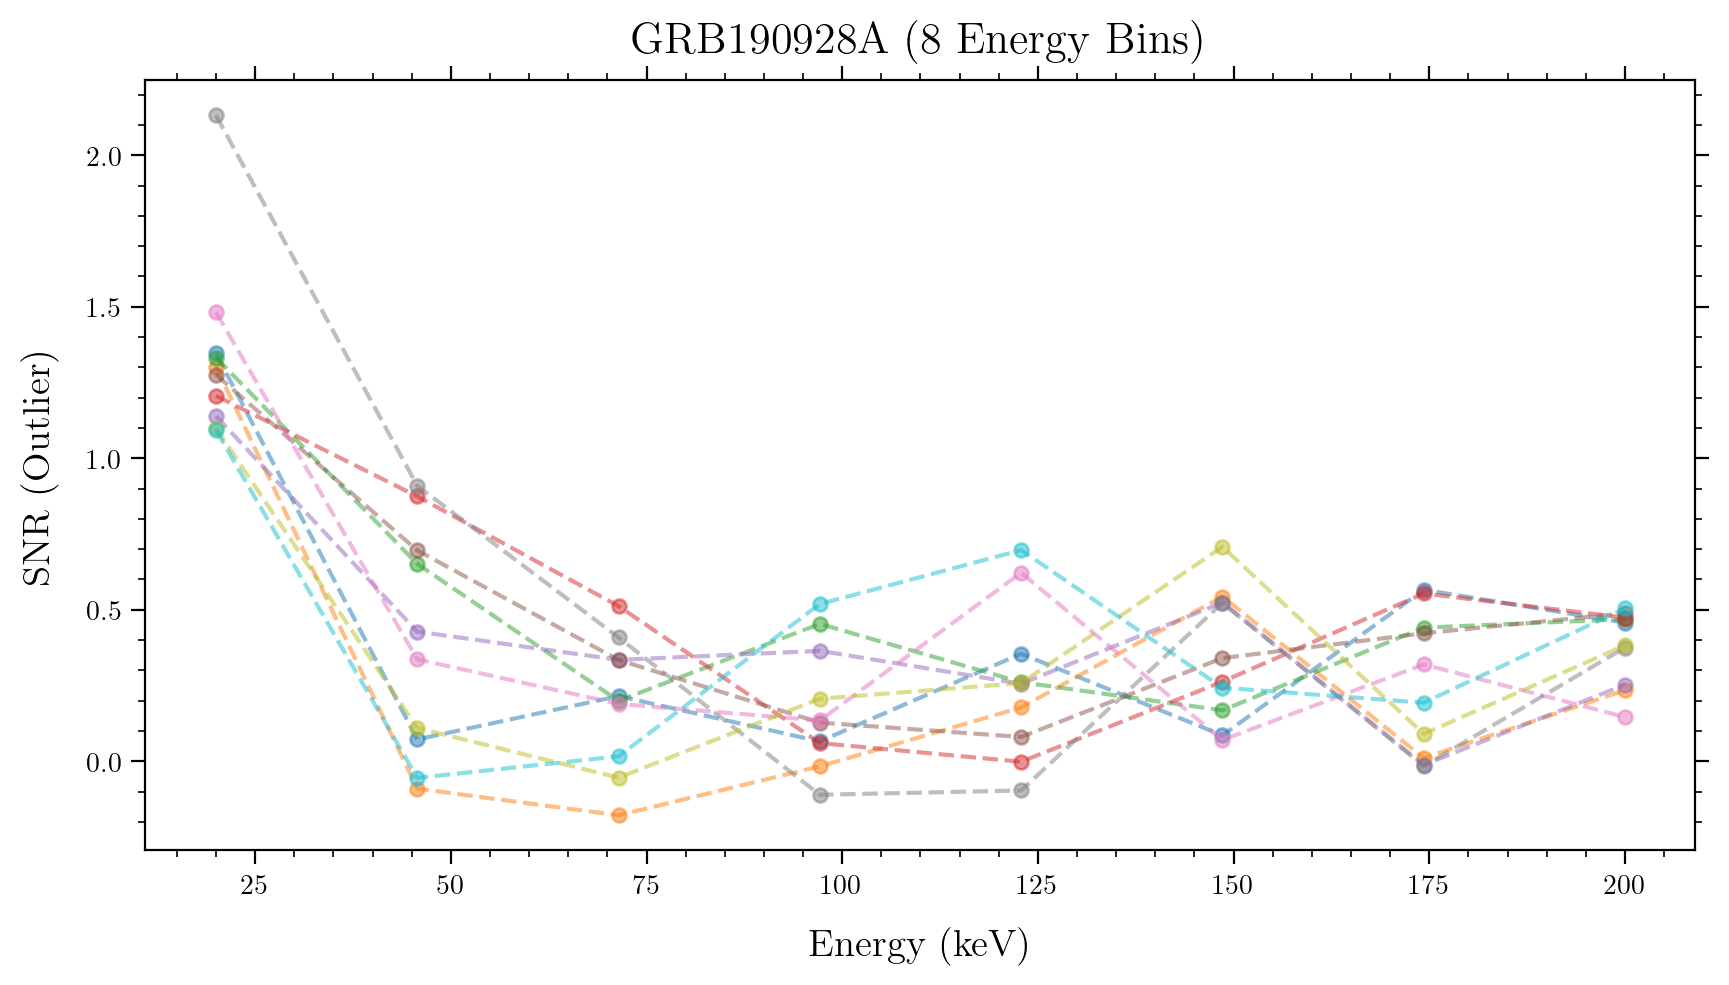

In [60]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_8, snr_8bin_outlier, marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("SNR (Outlier)", labelpad=10, fontsize=14)
plt.title("GRB190928A (8 Energy Bins)", pad=10, fontsize=16)
plt.show()

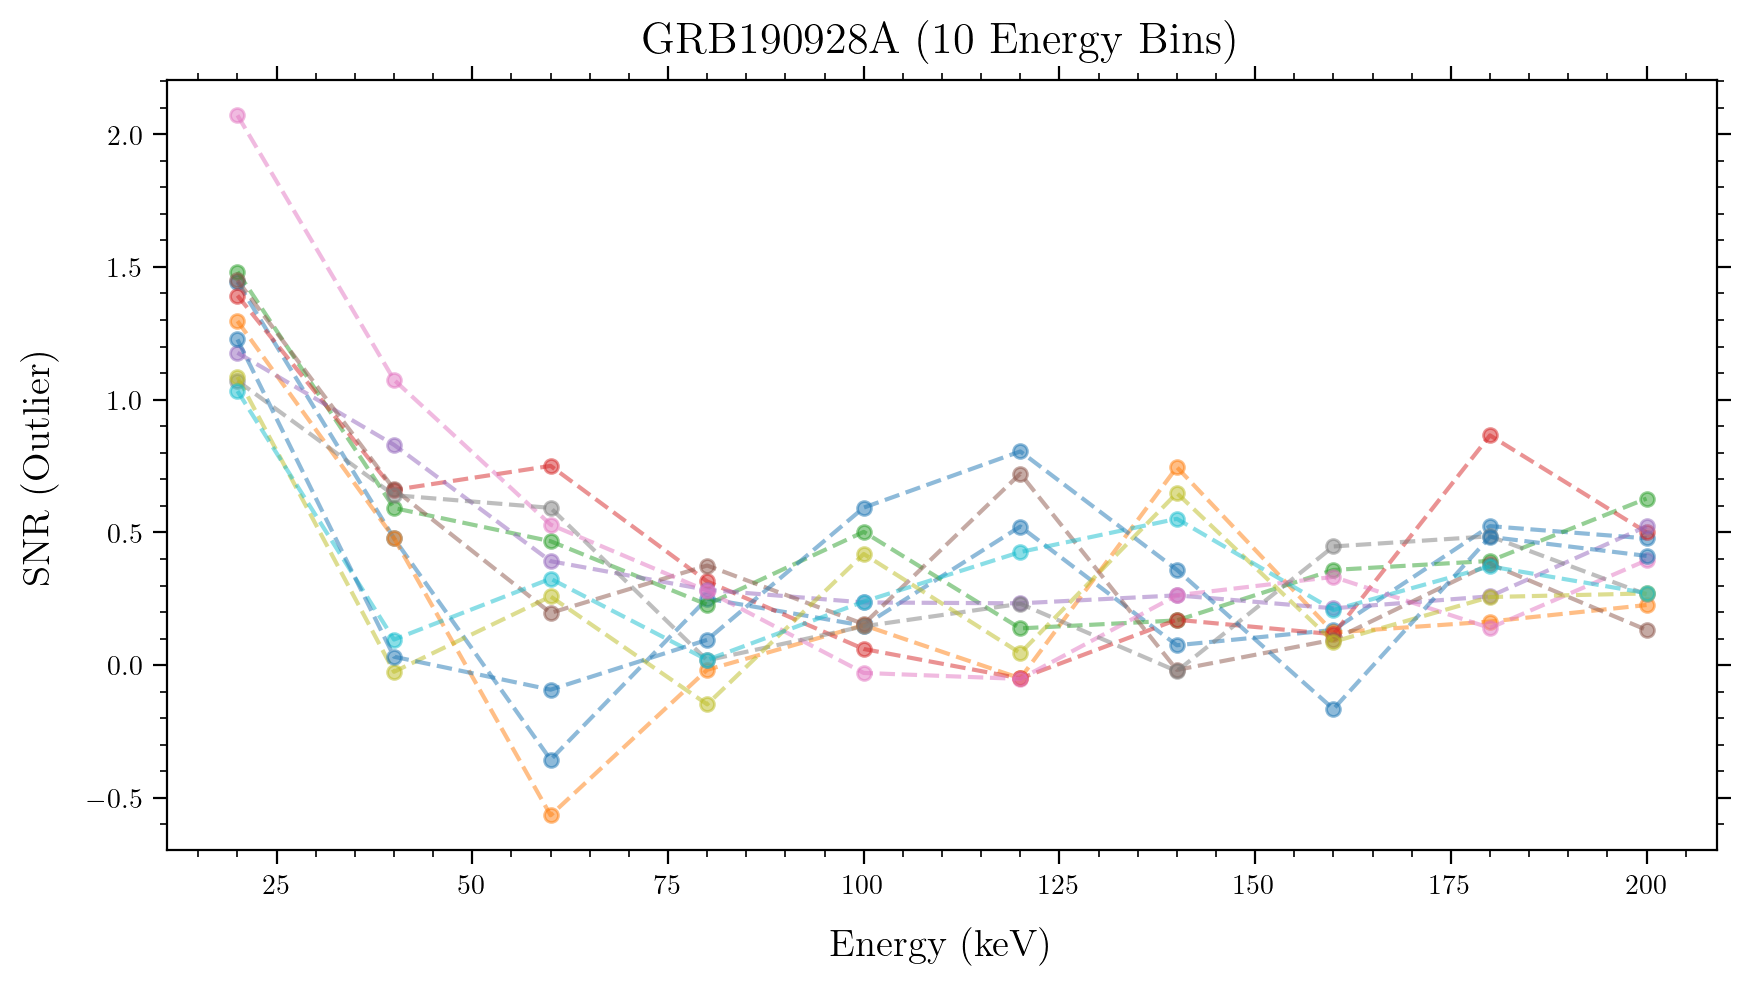

In [61]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x_10, snr_10bin_outlier, marker='o', markersize=5, linestyle='dashed', alpha=0.5)
plt.xlabel("Energy (keV)", labelpad=10, fontsize=14)
plt.ylabel("SNR (Outlier)", labelpad=10, fontsize=14)
plt.title("GRB190928A (10 Energy Bins)", pad=10, fontsize=16)
plt.show()